## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Prerequisites

In [1]:
import utils
import cv2
import matplotlib.pyplot as plt
import numpy as np
from moviepy.editor import VideoFileClip
from os import listdir
from ipywidgets import interact

from IPython.display import HTML

%matplotlib inline

print('done')

done


## Camera calibration

The code for this step is contained in method readCalibrationPoints at utils.py.
To perform the calibration of the camera I:
point 1
point 2

This is the code that performs these steps:


Once the calibration is done, I save it for future uses in a pickle file.

These are some images used during the calibration process.

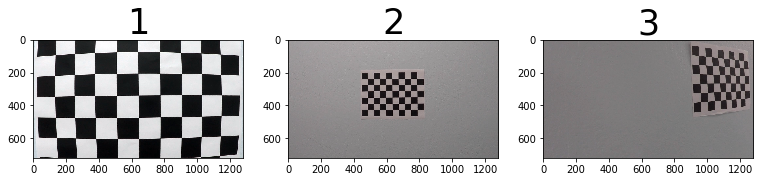

In [4]:
utils.displayImages( [[cv2.imread('camera_cal/calibration1.jpg'), '1', None], [cv2.imread('camera_cal/calibration6.jpg'), '2', None], [cv2.imread('camera_cal/calibration16.jpg'), '3', None]] )

This is a test of the distortion correction:

Reading calibration file camera_cal/calibration.p


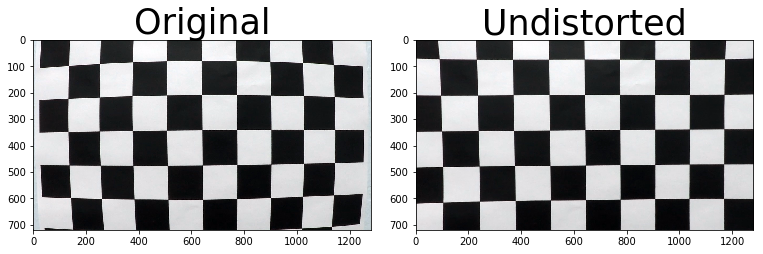

done


In [5]:
# 1. Camera calibration
mtx, dist = utils.calibrateCamera()
img = cv2.imread('camera_cal/calibration1.jpg')
if mtx is not None:
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    utils.displayImages([[img, 'Original', None], [undistorted, 'Undistorted', None]])

print('done')

## Pipeline (single images)

My pipeline will perform the following steps:
0. Read the image.
1. Apply the distortion correction.
2. Transform to perspective view.
3. Generate a thresholded binary image.
4. Do the lane lines search:
    1. Blind search at first.
    2. Targeted search when previous search is available.
5. Curve radius & offset from center. Draw results.

## 1. Read the image.

In [6]:
img = cv2.imread('test_images/'+listdir('test_images')[0])
# NOTE: We get the RGB image for displaying purposes.
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print('done')

done


## 2. Apply the distortion correction



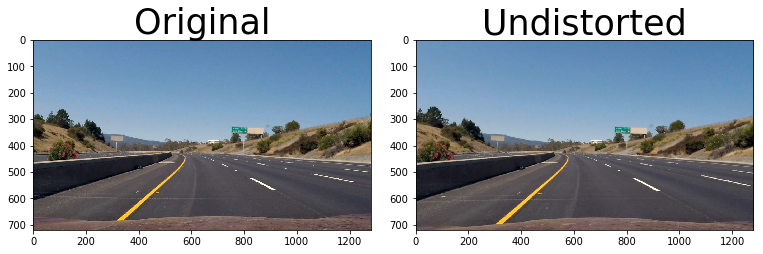

done


In [7]:
def distortionCorrection(img, mtx, dist, debug=False):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    if debug == True:
        utils.displayImages( [[img, 'Original', None], [undist, 'Undistorted', None]] )
    return undist

undist = distortionCorrection(RGB_img, mtx, dist, True)

print('done')

## 3. Transform to perspective view.

To create the relationship between original image (source, or src) and perspective-transformed image (destination, or dst), I have established the following correspondence:

|#|Src Points|Dst Points|
|-|-|-|
|DownLeft|(172,720)|(320, 720)|
|UpLeft|(586,450)|(320, 0)|
|UpRight|(690,450)|(960, 0)|
|DownRight|(1160,720)|(960, 720)|


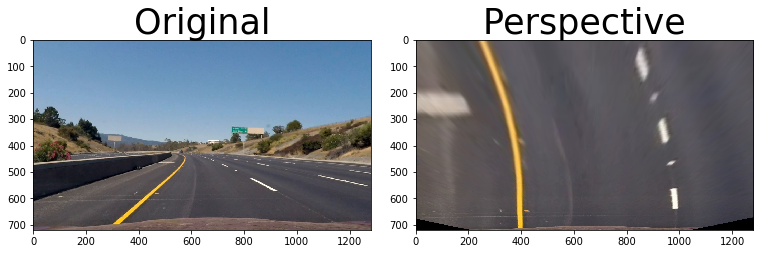

done


In [9]:
## The code for this step is contained in method perspectiveTransform at utils.py
src_frustrum = np.float32([[172,720], [586,450], [690,450], [1160,720]])
dst_frustrum = np.float32([[320, 720], [320, 0], [960, 0], [960, 720]])
def perspectiveTransform(img, src=src_frustrum, dst=dst_frustrum, debug=False):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    if debug == True:
        utils.displayImages( [[img, 'Original', None], [warped, 'Perspective', None]] )
    return warped, M


img_warped, perspective_M = perspectiveTransform(undist, src=src_frustrum, dst=dst_frustrum, debug=True)

print('done')

In [10]:
## Let´s sum up all these steps into a single one

def warpedRGBImage(imgname):
    img = cv2.imread(imgname)
    undist = distortionCorrection(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), mtx, dist)
    warped, M = perspectiveTransform(undist, src=src_frustrum, dst=dst_frustrum)
    return undist, warped, M

## 4. Generate a thresholded binary image.

In order to perform this step, we are going to do some research first in order to achieve the best result possible. We will explore different color spaces and gradient thresholds.

### Color filtering
First, let´s see some images in different color spaces: RGB, HSV, HLS, LAB, YCrCb.

In [11]:
def displayColorSpace(img, ch1Label, ch2Label, ch3Label):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 16))
    ax1.imshow(img[:,:,0], cmap='gray')
    ax1.set_title(ch1Label, fontsize=15)
    ax2.imshow(img[:,:,1], cmap='gray')
    ax2.set_title(ch2Label, fontsize=15)
    ax3.imshow(img[:,:,2], cmap='gray')
    ax3.set_title(ch3Label, fontsize=15)
    f.tight_layout()
    plt.show()

def displayAllColorSpaces(imgname):
    undist, warped, perspective_M = warpedRGBImage('test_images/' + imgname)
    displayColorSpace(warped, 'R', 'G', 'B')
    displayColorSpace(cv2.cvtColor(warped, cv2.COLOR_RGB2HLS), 'H', 'L', 'S')
    displayColorSpace(cv2.cvtColor(warped, cv2.COLOR_RGB2LAB), 'L', 'A', 'B')
    displayColorSpace(cv2.cvtColor(warped, cv2.COLOR_RGB2YCrCb), 'Y', 'Cr', 'Cb')


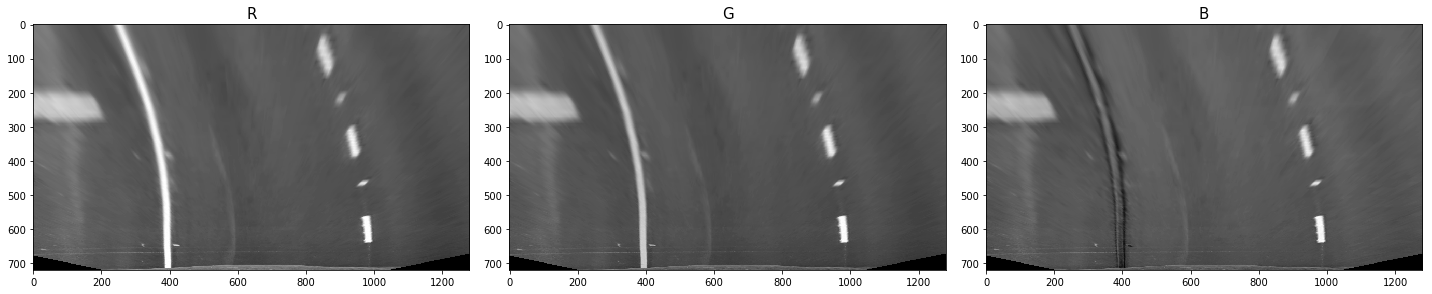

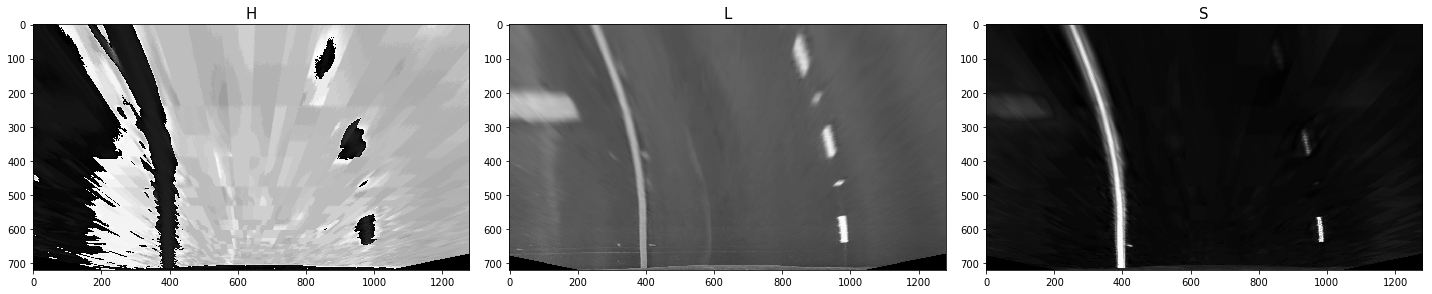

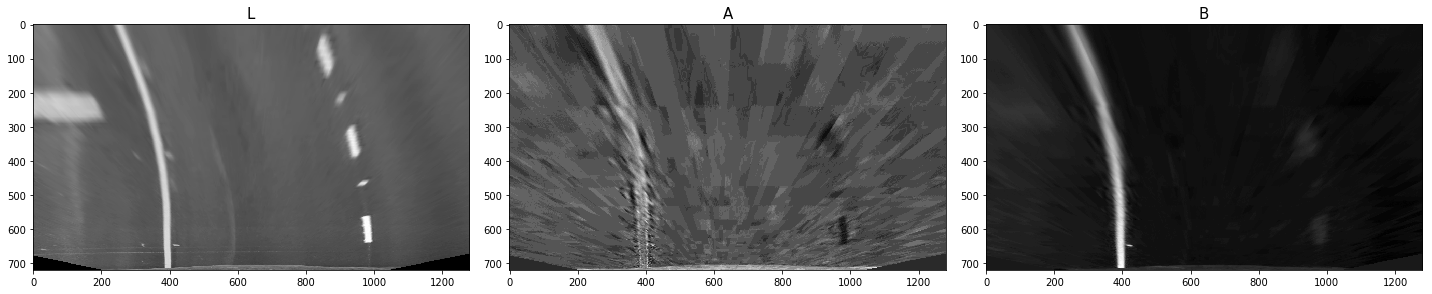

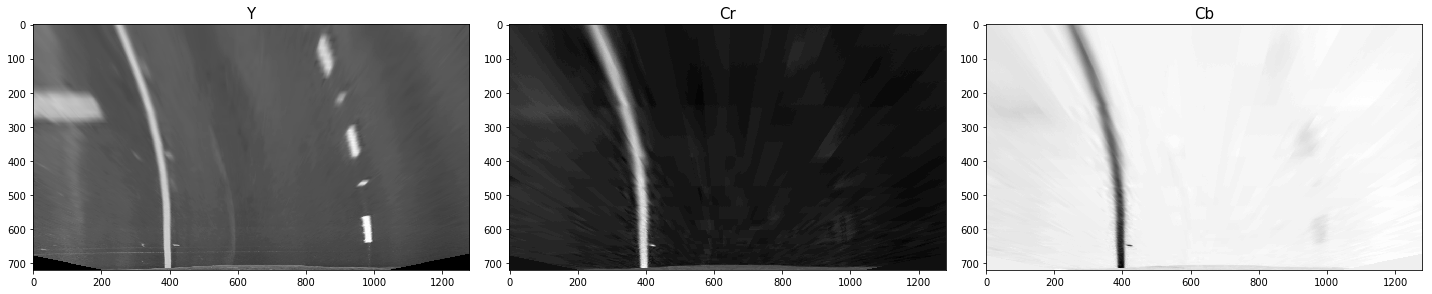

<function __main__.displayAllColorSpaces>

In [12]:
# Awesome tool right here
interact(displayAllColorSpaces, imgname=listdir('test_images'))

Lane lines will be white and yellow so let´s try to create color filters for that.

We can observe:
* HSV V Channel, HLS L Channel and YCrCb Y Channel show same results.
* LAB B Channel, YCrCB Cr Channel and YCrCB CB Channel are good for yellow lines.

We can try to use the first ones for white lanes, and the second for yellows.

Let´s play with the thresholds and the channels.


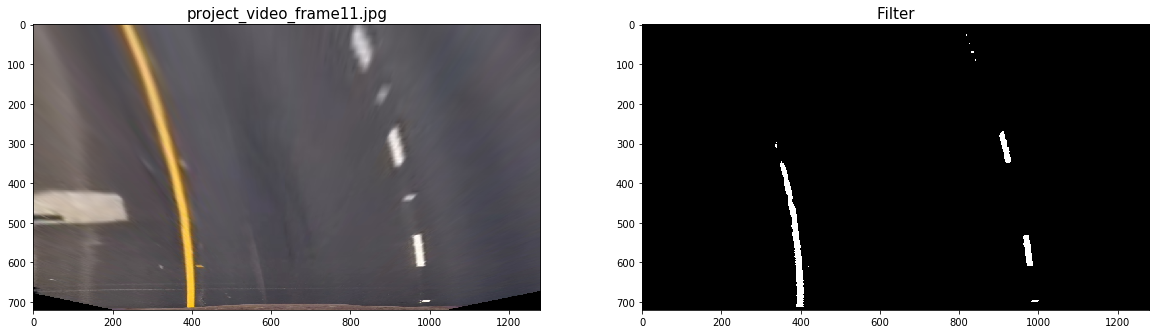

In [13]:
## Let´s use the interact tool to play with differente values and color spaces.
def getColorSpace(img, option):
    if option == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif  option == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif option == 'LAB':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    elif option == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

# Let´s try the L channel from HLS
def test_filter(imgname, cl1=['HSV', 'HLS', 'LAB', 'YCrCb'], ch1=(0,2,1),
                 cl2=['HSV', 'HLS', 'LAB', 'YCrCb'], ch2=(0,2,1),
                 operation=['|', '&', '^'], min_ch1=(0,255), max_ch1=(0,255), min_ch2=(0,255), max_ch2=(0,255)):
    
    undist, warped, perspective_M = warpedRGBImage('test_images/' + imgname)
    
    channel1 = getColorSpace(warped, cl1)[:,:,ch1]
    #channel1 = channel1*(255/np.max(channel1))
    #channel1 *= 255/np.max(channel1) # Faster

    channel2 = getColorSpace(warped, cl2)[:,:,ch2]
    #channel2 = channel2*(255/np.max(channel2))
    
    img_filtered = np.zeros_like(warped[:,:,0])
    if operation == '|':
        img_filtered[(channel1 > min_ch1) & (channel1 <= max_ch1) | (channel2 > min_ch2) & (channel2 <= max_ch2) ] = 1
    elif operation == '&':
        img_filtered[(channel1 > min_ch1) & (channel1 <= max_ch1) & (channel2 > min_ch2) & (channel2 <= max_ch2) ] = 1
    elif operation == '^':
        img_filtered[(channel1 > min_ch1) & (channel1 <= max_ch1) ^ (channel2 > min_ch2) & (channel2 <= max_ch2) ] = 1

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,16))
    ax1.imshow(warped)
    ax1.set_title(imgname, fontsize=15)
    ax2.imshow(img_filtered, cmap='gray')
    ax2.set_title('Filter', fontsize=15)

# Awesome tool right here
interact(test_filter, imgname=listdir('test_images'))


print('done')

After many test I came up with the following values:
* HLS L-Channel:
    * (210-255) For detecting white colors.
* LAB B-Channel:
    * (192-200) For detecting yellow colors.

### Gradient Transform
Now let´s apply some Sobel X gradient filter to focus on vertical lines and see whether it can bring more value to the pipeline.

In [14]:
## Sobel X on channel HLS S

def sobelx(img, hls_l_thresh=(210, 255), lx_thresh=(25, 60), lab_b_thres=(190, 255)):

    # Separate the chosen channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    hls_l_channel = hls[:,:,1]
    hls_s_channel = hls[:,:,2]
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB).astype(np.float)
    lab_b_channel = lab[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(hls_s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    lxbinary = np.zeros_like(scaled_sobel)
    lxbinary[(scaled_sobel >= lx_thresh[0]) & (scaled_sobel <= lx_thresh[1])] = 1
    
    # Threshold color channels
    l_binary = np.zeros_like(hls_l_channel)
    l_binary[(hls_l_channel >= hls_l_thresh[0]) & (hls_l_channel <= hls_l_thresh[1])] = 1
    b_binary = np.zeros_like(lab_b_channel)
    b_binary[(lab_b_channel > lab_b_thres[0]) & (lab_b_channel < lab_b_thres[1])] = 1
    
    combined_binary = np.zeros_like(lxbinary)
    combined_binary[(l_binary == 1) | (b_binary == 1) | (lxbinary == 1)] = 1
    
    return combined_binary

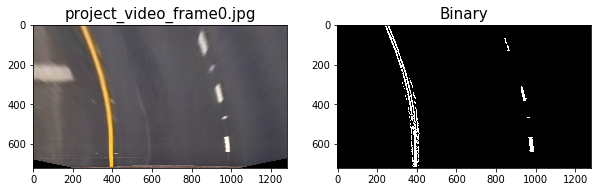

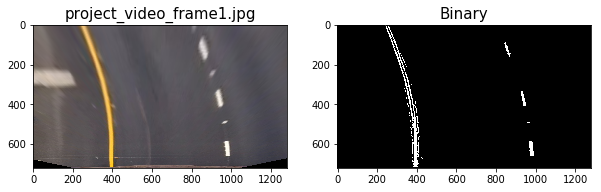

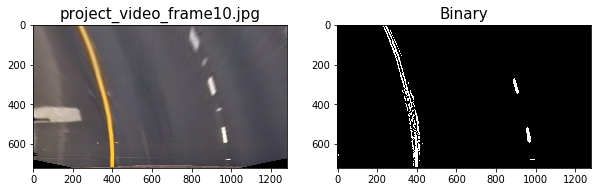

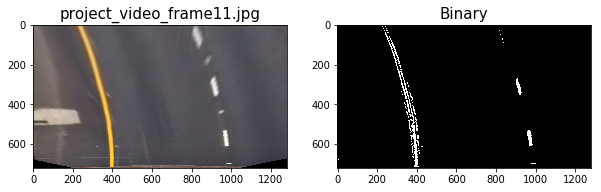

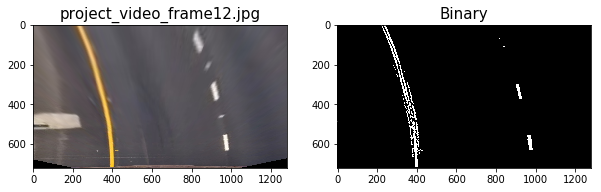

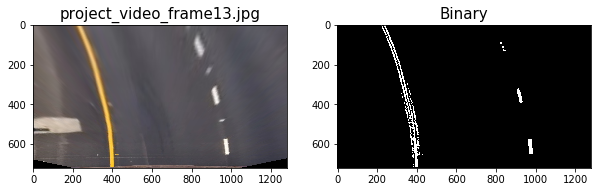

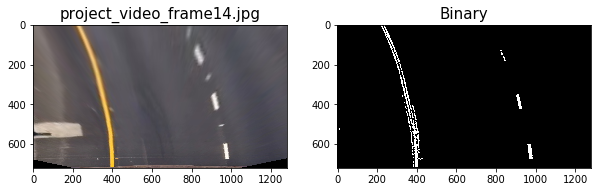

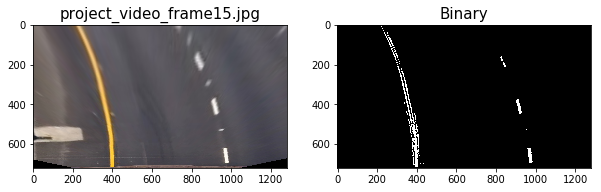

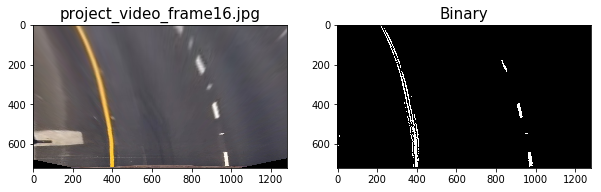

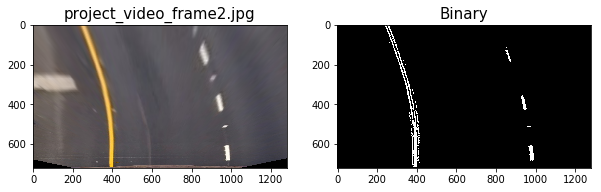

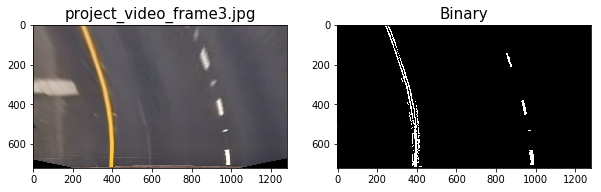

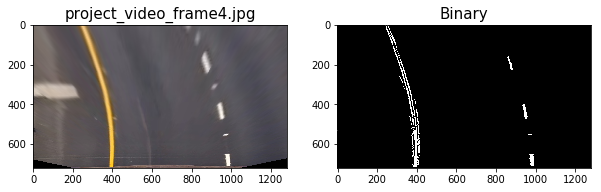

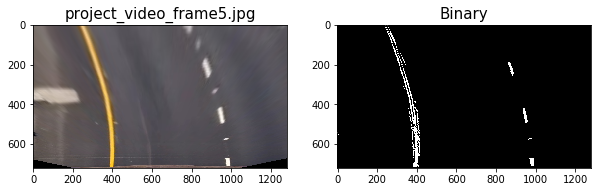

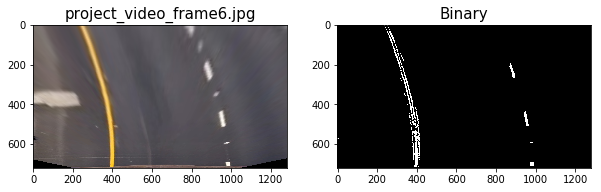

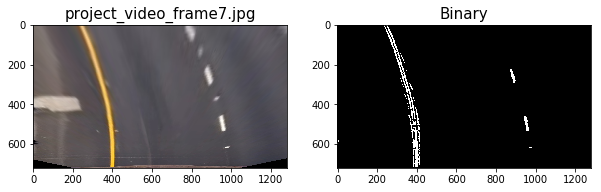

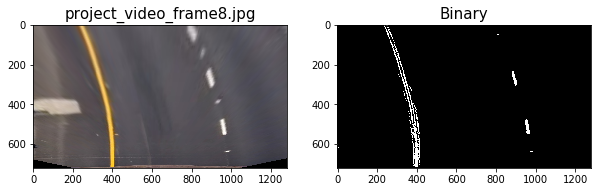

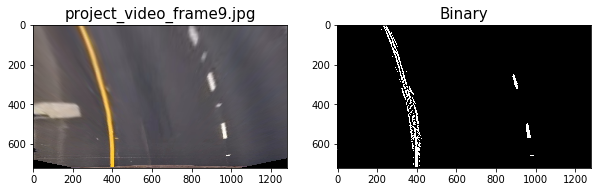

done


In [15]:
## Do more tests

def testBinaryImage(imgname):
    undist, warped, perspective_M = warpedRGBImage('test_images/' + imgname)
    binary_img = sobelx(warped)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))
    ax1.imshow(warped)
    ax1.set_title(imgname, fontsize=15)
    ax2.imshow(binary_img, cmap='gray')
    ax2.set_title('Binary', fontsize=15)
    plt.show()

for imgname in listdir('test_images'):
    testBinaryImage(imgname)
    
print('done')

And all together:

In [16]:
def get_binary_image(img, hls_l_thresh=(210, 255), lx_thresh=(25, 60), lab_b_thres=(192, 255)):

    # Separate the chosen channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    hls_l_channel = hls[:,:,1]
    hls_s_channel = hls[:,:,2]
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB).astype(np.float)
    lab_b_channel = lab[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(hls_s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    lxbinary = np.zeros_like(scaled_sobel)
    lxbinary[(scaled_sobel >= lx_thresh[0]) & (scaled_sobel <= lx_thresh[1])] = 1
    
    # Threshold color channels
    l_binary = np.zeros_like(hls_l_channel)
    l_binary[(hls_l_channel >= hls_l_thresh[0]) & (hls_l_channel <= hls_l_thresh[1])] = 1
    b_binary = np.zeros_like(lab_b_channel)
    b_binary[(lab_b_channel > lab_b_thres[0]) & (lab_b_channel < lab_b_thres[1])] = 1
    
    combined_binary = np.zeros_like(lxbinary)
    combined_binary[(l_binary == 1) | (b_binary == 1) | (lxbinary == 1)] = 1
    
    return combined_binary


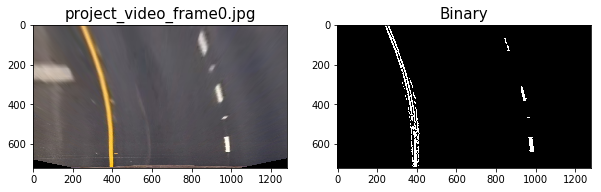

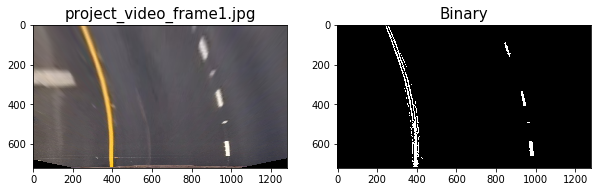

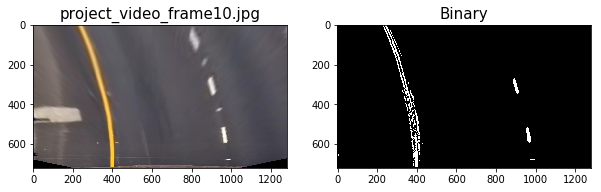

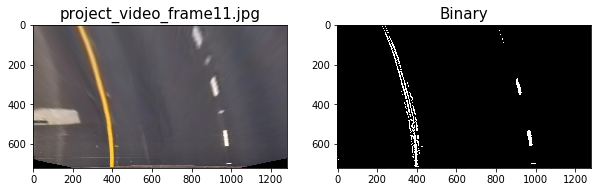

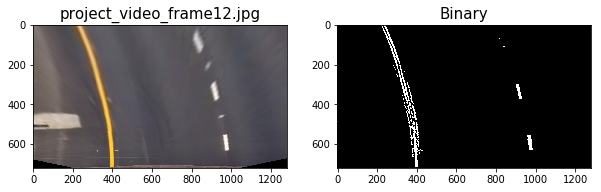

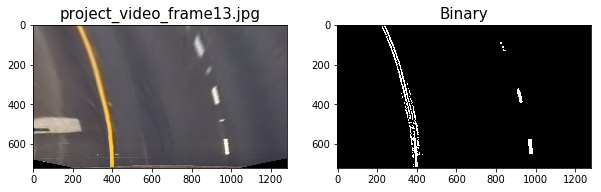

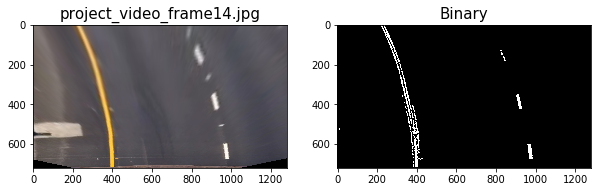

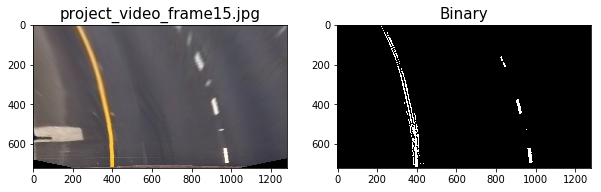

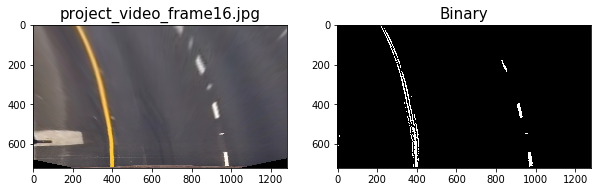

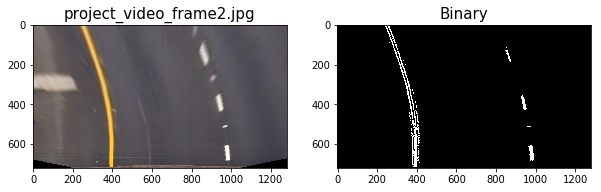

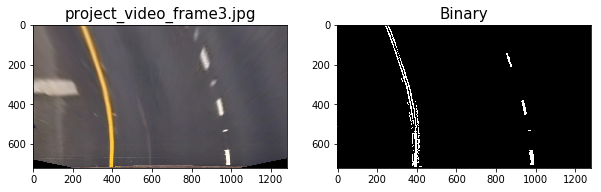

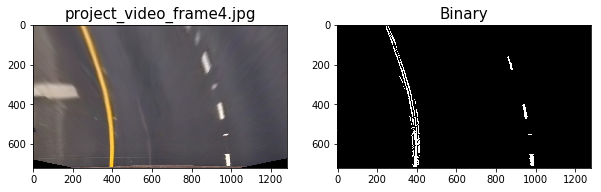

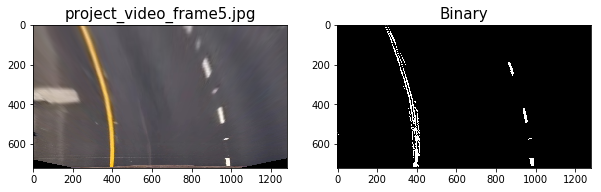

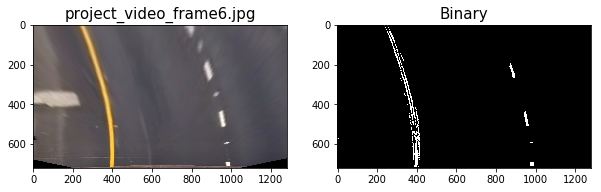

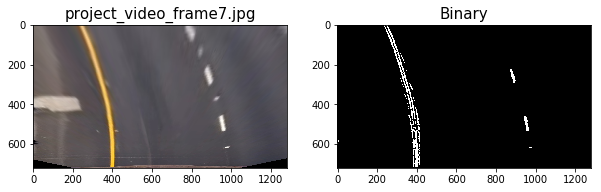

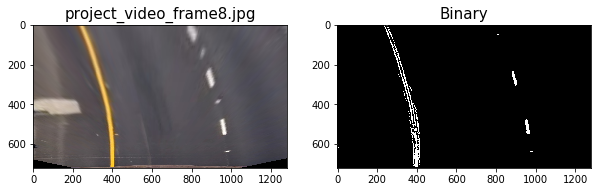

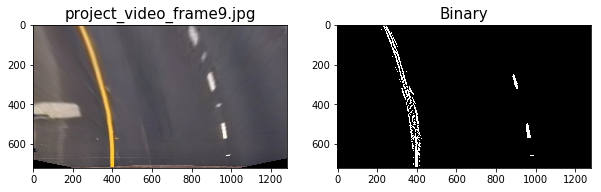

In [17]:
def testFinalBinaryImage(imgname):
    undist, warped, perspective_M = warpedRGBImage('test_images/' + imgname)
    binary_img = get_binary_image(warped)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))
    ax1.imshow(warped)
    ax1.set_title(imgname, fontsize=15)
    ax2.imshow(binary_img, cmap='gray')
    ax2.set_title('Binary', fontsize=15)
    plt.show()

for imgname in listdir('test_images'):
    testFinalBinaryImage(imgname)

## 5. Do a lane lines search:

Now that we have a decent binary image, we will try to find the lanes. We will use the methods shown in class: Implement Sliding Windows and Fit a Polynomial.

### A. Blind search.
For detecting the lane lines, we will use the method "Sliding Window Polyfit", starting from the bottom of the image to the top, dividing the image into 9 regions.

### B. Targeted search.
This method will use information from the previous frame in order to speed up the calculations.

In [18]:
def laneLinesBlindSearch(binary_warped, debug=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarterpoint = midpoint//2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #leftx_base = 400#quarterpoint
    #rightx_base = 900#midpoint + quarterpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    if debug == True:
        # Generate x and y values for plotting
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
        plt.plot(histogram)
        plt.show()
        
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, binary_warped.shape[1])
        plt.ylim(binary_warped.shape[0], 0)
        plt.show()

    return left_fit, right_fit

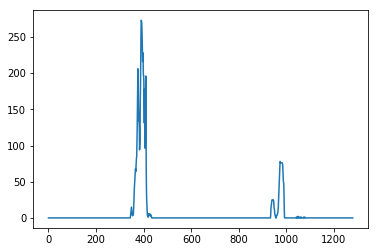

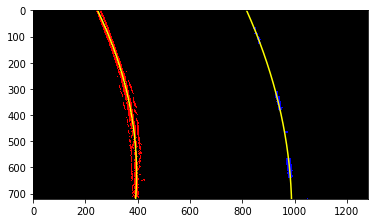

<function __main__.testBlindLaneSearch>

In [19]:
def testBlindLaneSearch(imgname):
    undist, warped, perspective_M = warpedRGBImage('test_images/' + imgname)
    binary_img = get_binary_image(warped)

    laneLinesBlindSearch(binary_img, True)

interact(testBlindLaneSearch, imgname=listdir('test_images'))

In [20]:
def laneLinesTargetedSearch(binary_warped, left_fit, right_fit, debug=False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin)))

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    if debug == True:
        # Generate x and y values for ploting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, binary_warped.shape[1])
        plt.ylim(binary_warped.shape[0], 0)
        plt.show()

    return left_fit, right_fit

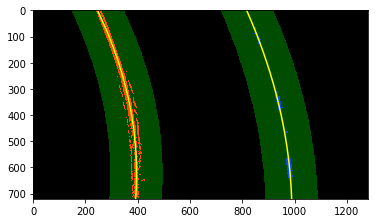

<function __main__.testTargetedLaneSearch>

In [21]:
def testTargetedLaneSearch(imgname):
    undist, warped, perspective_M = warpedRGBImage('test_images/' + imgname)
    binary_img = get_binary_image(warped)

    left_fit, right_fit = laneLinesBlindSearch(binary_img)
    left_fit, right_fit = laneLinesTargetedSearch(binary_img, left_fit, right_fit, True)

interact(testTargetedLaneSearch, imgname=listdir('test_images'))

### 6. Curve radius & offset from center. Draw the results

We are assuming:
* the camera is mounted at the center of the car.
* lanes of 30 meters long and 3.7 meters wide (around 700px in our images).

In [22]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def curvatureAndOffsetMeasurement(binary_warped, left_fit, right_fit, debug=False):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    ploty2 = ploty**2
    left_fitx = left_fit[0]*ploty2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty2 + right_fit[1]*ploty + right_fit[2]
    # Plot up the data
    if debug == True:
        plt.xlim(0, binary_warped.shape[1])
        plt.ylim(binary_warped.shape[0], 0)
        plt.plot(left_fitx, ploty, color='green', linewidth=3)
        plt.plot(right_fitx, ploty, color='green', linewidth=3)
        plt.show()

    #######
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    middleImg = binary_warped.shape[1]/2
    middleLane = (right_fitx[-1]-left_fitx[-1])/2

    # Now our radius of curvature is in meters
    print('LeftCurve:', left_curverad, 'm. RightCurve:', right_curverad, 'm. Middle: ', middleLane)

    return (left_curverad+right_curverad)/2, (middleImg-middleLane)*xm_per_pix


In [23]:
def drawFinalLines(image, binary_warped, radius, offset, perspective_M, left_fit, right_fit, debug=False):
    ##########
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    ##########

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    ploty2 = ploty**2
    left_fitx = left_fit[0]*ploty2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the binary_warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    ##########
    color_warp[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    color_warp[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ##########

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = np.linalg.inv(perspective_M)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.5, 0)

    # Write Text
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = 2
    fontColor              = (255,255,255)
    lineType               = 3

    offsetStr = 'Offset from center: {0:.2f}m'.format(offset)
    result = cv2.putText(result,offsetStr, (100, 75), font, fontScale, fontColor, lineType)
    radiusStr = 'Radius of curve: {0:.2f}m'.format(radius)
    result = cv2.putText(result, radiusStr, (100, 150), font, fontScale, fontColor, lineType)

    return result

LeftCurve: 429.413908851 m. RightCurve: 578.690793968 m. Middle:  298.129434529


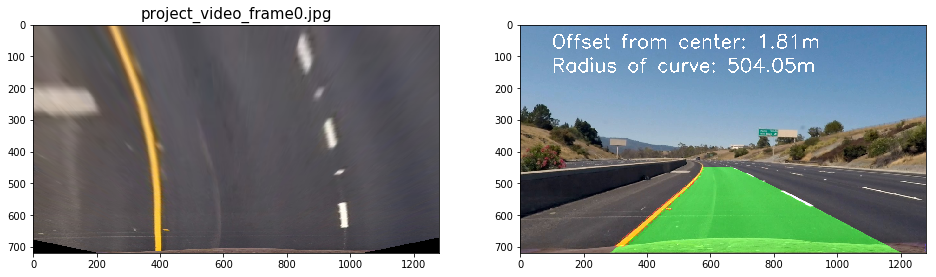

<function __main__.testPipeline>

In [24]:
def testPipeline(imgname):
    undist, warped, perspective_M = warpedRGBImage('test_images/' + imgname)
    binary_img = get_binary_image(warped)
    left_fit, right_fit = laneLinesBlindSearch(binary_img)
    left_fit, right_fit = laneLinesTargetedSearch(binary_img, left_fit, right_fit)
    radius, offset = curvatureAndOffsetMeasurement(binary_img, left_fit, right_fit)
    result = drawFinalLines(undist, binary_img, radius, offset, perspective_M, left_fit, right_fit)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    ax1.imshow(warped)
    ax1.set_title(imgname, fontsize=15)
    ax2.imshow(result, cmap='gray')
    plt.show()

interact(testPipeline, imgname=listdir('test_images'))

### Tracking the lane and Look-Ahead Filter

Time to review all and make some improvements.

There is no point in doing Blind Search in every frame, so we are going to keep track of the detected lines frame after frame to use that information in the future.

Using a Line class to avoid using blind search in every frame. After fitting a polynomial, then for each y position, we have an x position that represents the lane center from the last frame. So we search for the new line within +/- some margin around the old line center.

First let´s understand how the polyfit coefficients work under a sequence of frames of the same video

In [25]:
## Print fits for different frames to know the diff between them

imglist = listdir('test_coefficients')
# Item 0
undist, warped, perspective_M = warpedRGBImage('test_coefficients/' + imglist[0])
binary_img = get_binary_image(warped)
prev_left_fit, prev_right_fit = laneLinesBlindSearch(binary_img)
print('L:', prev_left_fit, ', R:', prev_left_fit)
for imgname in imglist[1:]:
    undist, warped, perspective_M = warpedRGBImage('test_coefficients/' + imgname)
    binary_img = get_binary_image(warped)
    left_fit, right_fit = laneLinesBlindSearch(binary_img)
    print('L:', left_fit, ', R:', right_fit)
    print('absL:', abs(prev_left_fit - left_fit), ', absR:', abs(prev_right_fit - right_fit))
    prev_left_fit, prev_right_fit = left_fit, right_fit

L: [ -3.93454866e-04   4.73345533e-01   2.32434763e+02] , R: [ -3.93454866e-04   4.73345533e-01   2.32434763e+02]
L: [ -3.98757142e-04   4.75912065e-01   2.33784119e+02] , R: [ -3.87789823e-04   5.63600586e-01   7.40814717e+02]
absL: [  5.30227630e-06   2.56653115e-03   1.34935533e+00] , absR: [  2.23697462e-05   2.76141376e-02   9.41523052e+00]
L: [ -3.90040836e-04   4.69227364e-01   2.34911360e+02] , R: [ -3.74014710e-04   5.47876313e-01   7.47033799e+02]
absL: [  8.71630587e-06   6.68470077e-03   1.12724148e+00] , absR: [  1.37751132e-05   1.57242730e-02   6.21908187e+00]
L: [ -3.72856289e-04   4.58095808e-01   2.36458474e+02] , R: [ -3.74479259e-04   5.50262654e-01   7.46792405e+02]
absL: [  1.71845476e-05   1.11315558e-02   1.54711393e+00] , absR: [  4.64548588e-07   2.38634148e-03   2.41393363e-01]
L: [ -3.67674052e-04   4.55703803e-01   2.34584551e+02] , R: [ -3.44578535e-04   5.04264286e-01   7.67913715e+02]
absL: [  5.18223647e-06   2.39200494e-03   1.87392265e+00] , absR: [  

During a sequence of frames from the same video the oscillation of coefficients are in the following order of magnitude:
[1.0-05   1.0e-02   1.0e+00]

In [38]:
# Define a class to receive the characteristics of each line detection

class Line():
    def __init__(self, width=1280, height=720, n=10):
        # last n iterations
        self.n = n
        self.w = width
        self.h = height
        self.ploty = np.linspace(0, self.h-1, self.h)
        self.ploty2 = self.ploty**2

        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line.
        self.recent_xfitted = []
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        # polynomial coefficients for the most recent fit
        self.current_fit = []#np.array([False])]
        # radius of curvature of the line in some units
        self.radius_of_curvature = None
        # distance in meters of vehicle center from the line
        self.line_base_pos = None
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        
    # Adds a new fit
    def add_fit(self, fit):
        #fit = np.polyfit(y, x, 2)
        fitx = fit[0]*self.ploty2 + fit[1]*self.ploty + fit[2]
        if fit is not None:
            if not self.detected or self.best_fit is None:
                self.detected = True
            else:
                # Check diff between fit and best fit
                self.diffs = abs(self.best_fit - fit)
                if self.diffs[0] < 0.01 and self.diffs[1] < 1.0 and self.diffs[2] < 100.0:
                    # We have a good fit.
                    self.detected = True
                else:
                    # We have a bad fit
                    self.detected = False

            if self.detected == True:
                self.recent_xfitted.append(fitx[-1])
                self.recent_xfitted = self.recent_xfitted[-self.n:]# Only keep n
                
                self.current_fit.append(fit)
                self.current_fit = self.current_fit[-self.n:]# Only keep n
                self.best_fit = np.average(self.current_fit, axis=0)

                # Fit new polynomials to x,y in world space
                fit_cr = np.polyfit(self.ploty*ym_per_pix, fitx*xm_per_pix, 2)
                # Calculate the new radii of curvature
                y_eval = self.ploty[-1]
                self.radius_of_curvature = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
                self.line_base_pos = self.recent_xfitted[-1]
        else:
            self.detected = False


Now refactor the pipeline to use this improvement

In [39]:
imglist = listdir('test_coefficients')
left_line = Line()
right_line = Line()
# Item 0
undist, warped, perspective_M = warpedRGBImage('test_coefficients/' + imglist[0])
binary_img = get_binary_image(warped)
left_fit, right_fit = laneLinesBlindSearch(binary_img)

left_line.add_fit(left_fit)
right_line.add_fit(right_fit)

for imgname in imglist[1:]:
    undist, warped, perspective_M = warpedRGBImage('test_coefficients/' + imgname)
    binary_img = get_binary_image(warped)
    if not left_line.detected or not right_line.detected:
        left_fit, right_fit = laneLinesBlindSearch(binary_img)
        left_line.add_fit(left_fit)
        right_line.add_fit(right_fit)
    else:
        print('Targeted search:', left_line.best_fit, right_line.best_fit)
        print('Compare with Blind:', laneLinesBlindSearch(binary_img))
        left_fit, right_fit = laneLinesTargetedSearch(binary_img, left_line.best_fit, right_line.best_fit)
        left_line.add_fit(left_fit)
        right_line.add_fit(right_fit)


Targeted search: [ -3.93454866e-04   4.73345533e-01   2.32434763e+02] [ -3.65420077e-04   5.35986448e-01   7.50229947e+02]
Compare with Blind: (array([ -3.98757142e-04,   4.75912065e-01,   2.33784119e+02]), array([ -3.87789823e-04,   5.63600586e-01,   7.40814717e+02]))
Targeted search: [ -3.96106004e-04   4.74628799e-01   2.33109441e+02] [ -3.74365415e-04   5.48001279e-01   7.45830734e+02]
Compare with Blind: (array([ -3.90040836e-04,   4.69227364e-01,   2.34911360e+02]), array([ -3.74014710e-04,   5.47876313e-01,   7.47033799e+02]))
Targeted search: [ -3.94084281e-04   4.72828321e-01   2.33710081e+02] [ -3.73315991e-04   5.47235034e-01   7.46348704e+02]
Compare with Blind: (array([ -3.72856289e-04,   4.58095808e-01,   2.36458474e+02]), array([ -3.74479259e-04,   5.50262654e-01,   7.46792405e+02]))
Targeted search: [ -3.88777283e-04   4.69145192e-01   2.34397179e+02] [ -3.73606808e-04   5.47991939e-01   7.46459630e+02]
Compare with Blind: (array([ -3.67674052e-04,   4.55703803e-01,   2

Targeted search: [ -4.16711439e-04   5.34313645e-01   2.23609703e+02] [ -3.39624392e-04   5.87697719e-01   7.28522996e+02]
Compare with Blind: (array([ -3.87893330e-04,   5.08557631e-01,   2.31830018e+02]), array([ -3.42518039e-04,   6.04240403e-01,   7.20575895e+02]))


## Pipeline: the code

Let´s define the final pipeline using the Line class:
0. Read the image.
1. Apply the distortion correction: method distortionCorrection
2. Transform to perspective view: method perspectiveTransform.
3. Generate a thresholded binary image: method get_binary_image.
4. Do the lane lines search:
    1. Blind search if there is no previous good fit: method laneLinesBlindSearch
    2. Targeted search when previous fit is available: method laneLinesTargetedSearch
5. Calculate the curve radius & offset from center: method curvatureAndOffsetMeasurement

In [40]:
# Let´s clean this up with the new Line class.

def process_image_pipeline(image):
    # image comes in BGR format
    RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    undist = utils.distortionCorrection(RGB_img, mtx, dist)
    img_warped, perspective_M = utils.perspectiveTransform(undist)
    binary_warped = utils.get_binary_image(img_warped)
    if not left_line.detected or not right_line.detected:
        left_fit, right_fit = laneLinesBlindSearch(binary_img)
        left_line.add_fit(left_fit)
        right_line.add_fit(right_fit)
    else:
        left_fit, right_fit = laneLinesTargetedSearch(binary_img, left_line.best_fit, right_line.best_fit)
        left_line.add_fit(left_fit)
        right_line.add_fit(right_fit)
    
    radius = (left_line.radius_of_curvature+right_line.radius_of_curvature)/2
    middleImg = binary_img.shape[1]/2
    middleLane = (left_line.line_base_pos + right_line.line_base_pos)/2
    offset = (middleImg-middleLane)*xm_per_pix
    result = utils.drawFinalLines(RGB_img, binary_warped, radius, offset, perspective_M, left_line.best_fit, right_line.best_fit)
    print('LeftCurve:', left_line.radius_of_curvature, 'm. RightCurve:', right_line.radius_of_curvature, 'm. Middle: ', middleLane)
    return result


## Pipeline (video)

Finally some real stuff

In [41]:
from moviepy.editor import VideoFileClip

video_name = 'project_video.mp4'
video_output = 'result.' + video_name

clip = VideoFileClip(video_name)
output_clip = clip.fl_image(process_image_pipeline)
%time output_clip.write_videofile(video_output, audio=False)

print('done')

LeftCurve: 423.405928747 m. RightCurve: 1092.42628471 m. Middle:  709.853260835
[MoviePy] >>>> Building video result.project_video.mp4
[MoviePy] Writing video result.project_video.mp4


  0%|          | 1/1261 [00:00<02:42,  7.76it/s]

LeftCurve: 423.405928747 m. RightCurve: 965.211396516 m. Middle:  710.760553178


  0%|          | 2/1261 [00:00<03:04,  6.83it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  0%|          | 3/1261 [00:00<03:16,  6.40it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  0%|          | 4/1261 [00:00<03:10,  6.58it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  0%|          | 5/1261 [00:00<03:06,  6.72it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  0%|          | 6/1261 [00:00<03:02,  6.86it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  1%|          | 7/1261 [00:01<03:03,  6.82it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  1%|          | 8/1261 [00:01<03:04,  6.79it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  1%|          | 9/1261 [00:01<03:05,  6.75it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  1%|          | 10/1261 [00:01<03:03,  6.83it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  1%|          | 11/1261 [00:01<03:04,  6.77it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  1%|          | 12/1261 [00:01<03:07,  6.65it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  1%|          | 13/1261 [00:01<03:09,  6.60it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  1%|          | 14/1261 [00:02<03:11,  6.50it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  1%|          | 15/1261 [00:02<03:14,  6.41it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  1%|▏         | 16/1261 [00:02<03:15,  6.38it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  1%|▏         | 17/1261 [00:02<03:16,  6.34it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  1%|▏         | 18/1261 [00:02<03:15,  6.37it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  2%|▏         | 19/1261 [00:02<03:08,  6.57it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  2%|▏         | 20/1261 [00:03<03:09,  6.55it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  2%|▏         | 21/1261 [00:03<03:12,  6.44it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  2%|▏         | 22/1261 [00:03<03:16,  6.30it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  2%|▏         | 23/1261 [00:03<03:19,  6.21it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  2%|▏         | 24/1261 [00:03<03:19,  6.20it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  2%|▏         | 25/1261 [00:03<03:18,  6.22it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  2%|▏         | 26/1261 [00:04<03:18,  6.23it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  2%|▏         | 27/1261 [00:04<03:11,  6.45it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  2%|▏         | 28/1261 [00:04<03:07,  6.57it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  2%|▏         | 30/1261 [00:04<03:14,  6.32it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  3%|▎         | 32/1261 [00:04<03:08,  6.52it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  3%|▎         | 34/1261 [00:05<03:04,  6.65it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  3%|▎         | 36/1261 [00:05<02:57,  6.89it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  3%|▎         | 38/1261 [00:05<02:54,  7.00it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  3%|▎         | 40/1261 [00:06<02:52,  7.08it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  3%|▎         | 42/1261 [00:06<02:49,  7.17it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  3%|▎         | 43/1261 [00:06<03:31,  5.75it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  4%|▎         | 45/1261 [00:07<03:49,  5.29it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  4%|▎         | 47/1261 [00:07<03:33,  5.67it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  4%|▍         | 48/1261 [00:07<03:52,  5.21it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  4%|▍         | 50/1261 [00:08<03:55,  5.14it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  4%|▍         | 52/1261 [00:08<03:42,  5.43it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  4%|▍         | 54/1261 [00:08<03:40,  5.48it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  4%|▍         | 56/1261 [00:09<03:37,  5.54it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  5%|▍         | 58/1261 [00:09<04:09,  4.82it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  5%|▍         | 60/1261 [00:09<03:51,  5.19it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  5%|▍         | 61/1261 [00:10<03:46,  5.30it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  5%|▍         | 63/1261 [00:10<03:49,  5.22it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  5%|▌         | 64/1261 [00:10<03:46,  5.29it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  5%|▌         | 65/1261 [00:10<03:57,  5.04it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  5%|▌         | 66/1261 [00:11<03:56,  5.06it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  5%|▌         | 68/1261 [00:11<03:58,  5.01it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  6%|▌         | 70/1261 [00:11<03:44,  5.30it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  6%|▌         | 72/1261 [00:12<03:42,  5.34it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  6%|▌         | 73/1261 [00:12<03:42,  5.33it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  6%|▌         | 75/1261 [00:12<03:53,  5.08it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  6%|▌         | 77/1261 [00:13<03:35,  5.50it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  6%|▌         | 78/1261 [00:13<03:27,  5.69it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  6%|▋         | 79/1261 [00:13<03:47,  5.19it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  6%|▋         | 81/1261 [00:14<03:47,  5.18it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  7%|▋         | 83/1261 [00:14<03:40,  5.35it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  7%|▋         | 85/1261 [00:14<03:50,  5.11it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  7%|▋         | 86/1261 [00:14<03:45,  5.21it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  7%|▋         | 88/1261 [00:15<03:36,  5.42it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  7%|▋         | 89/1261 [00:15<03:32,  5.52it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  7%|▋         | 92/1261 [00:16<03:42,  5.26it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  7%|▋         | 94/1261 [00:16<03:34,  5.43it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  8%|▊         | 96/1261 [00:16<03:22,  5.76it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  8%|▊         | 98/1261 [00:17<03:23,  5.71it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  8%|▊         | 99/1261 [00:17<03:25,  5.65it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  8%|▊         | 101/1261 [00:17<03:37,  5.34it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  8%|▊         | 103/1261 [00:18<03:32,  5.44it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  8%|▊         | 104/1261 [00:18<03:30,  5.49it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  8%|▊         | 105/1261 [00:18<03:49,  5.04it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  8%|▊         | 106/1261 [00:18<03:53,  4.95it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  9%|▊         | 108/1261 [00:19<03:41,  5.20it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  9%|▊         | 109/1261 [00:19<03:35,  5.35it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  9%|▉         | 111/1261 [00:19<03:34,  5.36it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  9%|▉         | 112/1261 [00:19<03:32,  5.41it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  9%|▉         | 115/1261 [00:20<03:39,  5.23it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  9%|▉         | 116/1261 [00:20<03:32,  5.38it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  9%|▉         | 118/1261 [00:20<03:30,  5.42it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


  9%|▉         | 119/1261 [00:21<03:26,  5.52it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 10%|▉         | 121/1261 [00:21<03:19,  5.71it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 10%|▉         | 123/1261 [00:21<03:26,  5.52it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 10%|▉         | 124/1261 [00:22<03:28,  5.44it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 10%|▉         | 126/1261 [00:22<03:30,  5.38it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 10%|█         | 127/1261 [00:22<03:22,  5.61it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747

 10%|█         | 129/1261 [00:23<03:31,  5.35it/s]

 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 10%|█         | 130/1261 [00:23<03:23,  5.55it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 10%|█         | 132/1261 [00:23<03:40,  5.11it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 11%|█         | 134/1261 [00:23<03:28,  5.41it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 11%|█         | 136/1261 [00:24<03:35,  5.23it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 11%|█         | 138/1261 [00:24<03:23,  5.52it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 11%|█         | 140/1261 [00:25<03:22,  5.52it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 11%|█▏        | 142/1261 [00:25<03:17,  5.67it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 11%|█▏        | 144/1261 [00:25<03:13,  5.77it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 12%|█▏        | 146/1261 [00:26<03:18,  5.63it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 12%|█▏        | 148/1261 [00:26<03:26,  5.39it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 12%|█▏        | 150/1261 [00:26<03:11,  5.80it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 12%|█▏        | 151/1261 [00:27<03:26,  5.39it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 12%|█▏        | 152/1261 [00:27<03:37,  5.10it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve:

 12%|█▏        | 153/1261 [00:27<03:39,  5.04it/s]

 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 12%|█▏        | 155/1261 [00:27<03:29,  5.29it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 12%|█▏        | 157/1261 [00:28<03:17,  5.58it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 13%|█▎        | 158/1261 [00:28<03:14,  5.67it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 13%|█▎        | 159/1261 [00:28<03:26,  5.34it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 13%|█▎        | 161/1261 [00:28<03:13,  5.69it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 13%|█▎        | 163/1261 [00:29<03:23,  5.40it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 13%|█▎        | 165/1261 [00:29<03:12,  5.68it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 13%|█▎        | 167/1261 [00:29<03:03,  5.98it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 13%|█▎        | 168/1261 [00:30<03:31,  5.16it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 13%|█▎        | 169/1261 [00:30<03:33,  5.11it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 13%|█▎        | 170/1261 [00:30<03:44,  4.86it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 

 14%|█▎        | 172/1261 [00:31<03:25,  5.29it/s]

423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 14%|█▎        | 173/1261 [00:31<03:29,  5.20it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 14%|█▍        | 175/1261 [00:31<03:22,  5.36it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 14%|█▍        | 176/1261 [00:31<03:30,  5.15it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 14%|█▍        | 178/1261 [00:32<03:39,  4.92it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 14%|█▍        | 181/1261 [00:32<03:25,  5.25it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 15%|█▍        | 183/1261 [00:33<03:06,  5.77it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 15%|█▍        | 184/1261 [00:33<03:07,  5.75it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 15%|█▍        | 185/1261 [00:33<03:25,  5.23it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 15%|█▍        | 187/1261 [00:33<03:15,  5.50it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 15%|█▍        | 189/1261 [00:34<03:07,  5.72it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 15%|█▌        | 190/1261 [00:34<03:20,  5.34it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 15%|█▌        | 192/1261 [00:34<03:21,  5.32it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 15%|█▌        | 194/1261 [00:35<03:07,  5.68it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 15%|█▌        | 195/1261 [00:35<03:00,  5.92it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 16%|█▌        | 198/1261 [00:35<03:09,  5.62it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 16%|█▌        | 199/1261 [00:35<03:05,  5.72it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496

 16%|█▌        | 201/1261 [00:36<03:10,  5.55it/s]

 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 16%|█▌        | 203/1261 [00:36<03:11,  5.52it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 16%|█▌        | 204/1261 [00:36<03:30,  5.03it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 16%|█▋        | 206/1261 [00:37<03:26,  5.10it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 16%|█▋        | 208/1261 [00:37<03:15,  5.37it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 17%|█▋        | 209/1261 [00:37<03:08,  5.57it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 17%|█▋        | 211/1261 [00:38<03:12,  5.47it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 17%|█▋        | 213/1261 [00:38<02:58,  5.86it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 17%|█▋        | 215/1261 [00:38<03:06,  5.60it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 17%|█▋        | 216/1261 [00:39<03:10,  5.50it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 17%|█▋        | 218/1261 [00:39<03:23,  5.13it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 18%|█▊        | 221/1261 [00:40<03:15,  5.32it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 18%|█▊        | 223/1261 [00:40<03:09,  5.49it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 18%|█▊        | 225/1261 [00:40<02:53,  5.98it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 18%|█▊        | 227/1261 [00:41<03:07,  5.52it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 18%|█▊        | 228/1261 [00:41<03:06,  5.53it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 18%|█▊        | 229/1261 [00:41<03:13,  5.32it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 18%|█▊        | 231/1261 [00:41<03:02,  5.63it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 18%|█▊        | 233/1261 [00:42<03:06,  5.50it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 19%|█▊        | 235/1261 [00:42<03:07,  5.48it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 19%|█▉        | 237/1261 [00:43<03:04,  5.54it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 19%|█▉        | 239/1261 [00:43<03:00,  5.67it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 19%|█▉        | 241/1261 [00:43<02:51,  5.96it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 19%|█▉        | 243/1261 [00:44<02:54,  5.82it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 19%|█▉        | 244/1261 [00:44<02:55,  5.80it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 19%|█▉        | 245/1261 [00:44<03:08,  5.38it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 20%|█▉        | 247/1261 [00:44<03:19,  5.07it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 20%|█▉        | 249/1261 [00:45<03:19,  5.07it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 20%|█▉        | 250/1261 [00:45<03:57,  4.25it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 20%|█▉        | 251/1261 [00:45<04:05,  4.12it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 20%|█▉        | 252/1261 [00:46<04:12,  3.99it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 20%|██        | 253/1261 [00:46<04:14,  3.96it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 20%|██        | 254/1261 [00:46<04:03,  4.13it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 20%|██        | 255/1261 [00:46<03:59,  4.20it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 20%|██        | 256/1261 [00:47<03:52,  4.32it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 20%|██        | 257/1261 [00:47<03:47,  4.42it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 20%|██        | 258/1261 [00:47<03:41,  4.54it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 21%|██        | 260/1261 [00:47<03:30,  4.75it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 21%|██        | 261/1261 [00:48<03:27,  4.81it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 21%|██        | 262/1261 [00:48<03:32,  4.70it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 21%|██        | 264/1261 [00:48<03:19,  5.00it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 21%|██        | 265/1261 [00:48<03:15,  5.09it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 21%|██        | 267/1261 [00:49<03:14,  5.10it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 21%|██▏       | 269/1261 [00:49<03:24,  4.84it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 21%|██▏       | 270/1261 [00:50<04:09,  3.98it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 21%|██▏       | 271/1261 [00:50<04:22,  3.78it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 22%|██▏       | 273/1261 [00:50<04:00,  4.11it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 22%|██▏       | 274/1261 [00:51<03:54,  4.20it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 22%|██▏       | 276/1261 [00:51<03:30,  4.68it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 22%|██▏       | 278/1261 [00:51<03:06,  5.27it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 22%|██▏       | 280/1261 [00:52<02:58,  5.51it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 22%|██▏       | 282/1261 [00:52<02:52,  5.66it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 23%|██▎       | 284/1261 [00:52<03:00,  5.41it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 23%|██▎       | 285/1261 [00:53<02:55,  5.56it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 23%|██▎       | 286/1261 [00:53<03:15,  5.00it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 23%|██▎       | 287/1261 [00:53<03:17,  4.92it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 23%|██▎       | 290/1261 [00:54<03:01,  5.35it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 23%|██▎       | 291/1261 [00:54<03:03,  5.28it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 23%|██▎       | 292/1261 [00:54<03:08,  5.15it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 23%|██▎       | 294/1261 [00:54<02:58,  5.41it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 23%|██▎       | 296/1261 [00:55<03:00,  5.33it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 24%|██▎       | 297/1261 [00:55<02:54,  5.53it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 24%|██▎       | 299/1261 [00:55<02:57,  5.41it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 24%|██▍       | 301/1261 [00:56<03:01,  5.28it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 24%|██▍       | 303/1261 [00:56<03:05,  5.16it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 24%|██▍       | 305/1261 [00:56<02:57,  5.38it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 24%|██▍       | 307/1261 [00:57<02:56,  5.41it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 24%|██▍       | 308/1261 [00:57<03:07,  5.08it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 25%|██▍       | 309/1261 [00:57<03:14,  4.90it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 25%|██▍       | 310/1261 [00:57<03:23,  4.67it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 25%|██▍       | 312/1261 [00:58<03:06,  5.09it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 25%|██▍       | 315/1261 [00:58<02:55,  5.38it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 25%|██▌       | 317/1261 [00:59<02:50,  5.53it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 25%|██▌       | 319/1261 [00:59<02:55,  5.37it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 25%|██▌       | 321/1261 [00:59<02:47,  5.62it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 26%|██▌       | 322/1261 [01:00<02:52,  5.46it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 26%|██▌       | 324/1261 [01:00<02:51,  5.47it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 26%|██▌       | 326/1261 [01:00<02:44,  5.69it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 26%|██▌       | 327/1261 [01:01<02:38,  5.91it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 26%|██▌       | 329/1261 [01:01<02:42,  5.75it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 26%|██▌       | 330/1261 [01:01<02:52,  5.39it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 26%|██▌       | 331/1261 [01:01<02:55,  5.31it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 26%|██▋       | 333/1261 [01:02<02:54,  5.32it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 26%|██▋       | 334/1261 [01:02<02:49,  5.48it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 27%|██▋       | 336/1261 [01:02<02:46,  5.55it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 27%|██▋       | 338/1261 [01:03<02:46,  5.54it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 27%|██▋       | 340/1261 [01:03<02:36,  5.89it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 27%|██▋       | 341/1261 [01:03<02:38,  5.82it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 27%|██▋       | 343/1261 [01:03<02:43,  5.61it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 27%|██▋       | 344/1261 [01:04<02:50,  5.38it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 28%|██▊       | 347/1261 [01:04<02:50,  5.35it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 28%|██▊       | 349/1261 [01:05<02:51,  5.31it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 28%|██▊       | 351/1261 [01:05<02:39,  5.70it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 28%|██▊       | 353/1261 [01:05<02:32,  5.96it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 28%|██▊       | 355/1261 [01:06<02:35,  5.84it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 28%|██▊       | 357/1261 [01:06<02:31,  5.95it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 28%|██▊       | 358/1261 [01:06<02:39,  5.67it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 28%|██▊       | 359/1261 [01:06<02:51,  5.26it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 29%|██▊       | 361/1261 [01:07<02:44,  5.46it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 29%|██▉       | 363/1261 [01:07<02:47,  5.37it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 29%|██▉       | 364/1261 [01:07<02:57,  5.06it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 29%|██▉       | 367/1261 [01:08<02:38,  5.63it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 29%|██▉       | 369/1261 [01:08<02:33,  5.80it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 29%|██▉       | 371/1261 [01:09<02:31,  5.89it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 30%|██▉       | 373/1261 [01:09<02:41,  5.49it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 30%|██▉       | 374/1261 [01:09<03:05,  4.79it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 30%|██▉       | 376/1261 [01:10<02:53,  5.09it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 30%|██▉       | 378/1261 [01:10<02:30,  5.86it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 30%|███       | 380/1261 [01:10<02:31,  5.81it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 30%|███       | 382/1261 [01:11<02:39,  5.51it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 30%|███       | 383/1261 [01:11<02:31,  5.80it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 30%|███       | 384/1261 [01:11<02:47,  5.23it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 31%|███       | 386/1261 [01:11<03:00,  4.86it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 31%|███       | 388/1261 [01:12<02:51,  5.09it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 31%|███       | 389/1261 [01:12<02:39,  5.48it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 31%|███       | 390/1261 [01:12<02:59,  4.86it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 31%|███       | 392/1261 [01:13<02:49,  5.13it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 31%|███       | 394/1261 [01:13<02:44,  5.28it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 31%|███▏      | 395/1261 [01:13<02:54,  4.95it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 31%|███▏      | 397/1261 [01:14<02:45,  5.21it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 32%|███▏      | 398/1261 [01:14<02:35,  5.54it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 32%|███▏      | 400/1261 [01:14<02:37,  5.46it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 32%|███▏      | 402/1261 [01:15<02:39,  5.38it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 32%|███▏      | 404/1261 [01:15<02:44,  5.21it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 32%|███▏      | 405/1261 [01:15<02:59,  4.77it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 32%|███▏      | 406/1261 [01:15<03:05,  4.61it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 32%|███▏      | 407/1261 [01:16<03:01,  4.71it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 32%|███▏      | 409/1261 [01:16<02:42,  5.23it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 33%|███▎      | 411/1261 [01:16<02:48,  5.04it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 33%|███▎      | 412/1261 [01:17<02:46,  5.11it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 33%|███▎      | 413/1261 [01:17<02:50,  4.97it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 33%|███▎      | 415/1261 [01:17<02:49,  5.00it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 33%|███▎      | 417/1261 [01:18<02:42,  5.18it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 33%|███▎      | 419/1261 [01:18<02:45,  5.09it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 33%|███▎      | 421/1261 [01:18<02:34,  5.43it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 33%|███▎      | 422/1261 [01:19<02:38,  5.30it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 34%|███▎      | 423/1261 [01:19<02:52,  4.87it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 34%|███▎      | 424/1261 [01:19<02:57,  4.70it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 34%|███▎      | 425/1261 [01:19<02:55,  4.76it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 34%|███▍      | 426/1261 [01:19<03:14,  4.30it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 34%|███▍      | 428/1261 [01:20<03:05,  4.50it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 34%|███▍      | 430/1261 [01:20<02:46,  5.00it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 34%|███▍      | 431/1261 [01:21<02:55,  4.72it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 34%|███▍      | 432/1261 [01:21<03:05,  4.48it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 34%|███▍      | 433/1261 [01:21<03:08,  4.38it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 34%|███▍      | 435/1261 [01:21<02:55,  4.72it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 35%|███▍      | 436/1261 [01:22<02:59,  4.59it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 35%|███▍      | 437/1261 [01:22<02:56,  4.67it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 35%|███▍      | 438/1261 [01:22<03:05,  4.43it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 35%|███▍      | 440/1261 [01:23<03:00,  4.56it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 35%|███▍      | 441/1261 [01:23<03:03,  4.47it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 35%|███▌      | 442/1261 [01:23<03:05,  4.41it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 35%|███▌      | 443/1261 [01:23<03:06,  4.39it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 35%|███▌      | 444/1261 [01:23<03:11,  4.26it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 35%|███▌      | 445/1261 [01:24<03:15,  4.17it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 35%|███▌      | 446/1261 [01:24<03:20,  4.07it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 

 36%|███▌      | 448/1261 [01:24<03:06,  4.36it/s]

784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 36%|███▌      | 451/1261 [01:25<02:52,  4.69it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 36%|███▌      | 453/1261 [01:25<02:42,  4.97it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 36%|███▌      | 454/1261 [01:26<02:40,  5.03it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 36%|███▌      | 455/1261 [01:26<02:46,  4.85it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 36%|███▌      | 457/1261 [01:26<02:32,  5.28it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 36%|███▋      | 459/1261 [01:27<02:24,  5.54it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 36%|███▋      | 460/1261 [01:27<02:37,  5.09it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 37%|███▋      | 461/1261 [01:27<02:39,  5.00it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 37%|███▋      | 462/1261 [01:27<02:50,  4.70it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 37%|███▋      | 465/1261 [01:28<02:27,  5.38it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 37%|███▋      | 466/1261 [01:28<02:50,  4.66it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 37%|███▋      | 468/1261 [01:28<02:41,  4.90it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 37%|███▋      | 469/1261 [01:29<02:28,  5.32it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve:

 37%|███▋      | 471/1261 [01:29<02:28,  5.32it/s]

 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 38%|███▊      | 473/1261 [01:29<02:28,  5.31it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 38%|███▊      | 475/1261 [01:30<02:16,  5.75it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 38%|███▊      | 476/1261 [01:30<02:16,  5.77it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve:

 38%|███▊      | 477/1261 [01:30<02:23,  5.46it/s]

 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 38%|███▊      | 480/1261 [01:31<02:24,  5.41it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 38%|███▊      | 481/1261 [01:31<02:20,  5.55it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 38%|███▊      | 484/1261 [01:31<02:18,  5.62it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 38%|███▊      | 485/1261 [01:32<02:28,  5.22it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 39%|███▊      | 486/1261 [01:32<02:39,  4.87it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 

 39%|███▊      | 487/1261 [01:32<02:39,  4.86it/s]

423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 39%|███▉      | 489/1261 [01:32<02:25,  5.32it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 39%|███▉      | 490/1261 [01:33<02:35,  4.97it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 39%|███▉      | 492/1261 [01:33<02:33,  5.00it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 39%|███▉      | 493/1261 [01:33<02:33,  4.99it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 39%|███▉      | 494/1261 [01:33<02:39,  4.81it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 39%|███▉      | 497/1261 [01:34<02:22,  5.36it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 40%|███▉      | 499/1261 [01:34<02:13,  5.69it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 40%|███▉      | 501/1261 [01:35<02:19,  5.45it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 40%|███▉      | 503/1261 [01:35<02:23,  5.29it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 40%|████      | 505/1261 [01:35<02:11,  5.77it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 40%|████      | 506/1261 [01:36<02:32,  4.96it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 40%|████      | 509/1261 [01:36<02:25,  5.16it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 40%|████      | 510/1261 [01:36<02:25,  5.15it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 41%|████      | 512/1261 [01:37<02:26,  5.11it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 41%|████      | 513/1261 [01:37<02:26,  5.10it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 41%|████      | 515/1261 [01:37<02:25,  5.13it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 41%|████      | 517/1261 [01:38<02:12,  5.60it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 41%|████      | 519/1261 [01:38<02:15,  5.47it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 41%|████      | 520/1261 [01:38<02:17,  5.39it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle: 

 41%|████▏     | 522/1261 [01:39<02:17,  5.39it/s]

 712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 41%|████▏     | 523/1261 [01:39<02:13,  5.54it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 42%|████▏     | 525/1261 [01:39<02:17,  5.35it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 42%|████▏     | 527/1261 [01:40<02:15,  5.44it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 42%|████▏     | 528/1261 [01:40<02:24,  5.09it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 

 42%|████▏     | 530/1261 [01:40<02:18,  5.29it/s]

423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 42%|████▏     | 532/1261 [01:41<02:07,  5.73it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 42%|████▏     | 533/1261 [01:41<02:13,  5.45it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 42%|████▏     | 535/1261 [01:41<02:13,  5.45it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 43%|████▎     | 537/1261 [01:41<02:03,  5.86it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 43%|████▎     | 538/1261 [01:42<02:04,  5.81it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 43%|████▎     | 540/1261 [01:42<02:11,  5.48it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 43%|████▎     | 542/1261 [01:42<02:07,  5.64it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 43%|████▎     | 543/1261 [01:43<02:10,  5.52it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 43%|████▎     | 544/1261 [01:43<02:16,  5.24it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 43%|████▎     | 546/1261 [01:43<02:06,  5.64it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 43%|████▎     | 547/1261 [01:43<02:05,  5.67it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 44%|████▎     | 549/1261 [01:44<02:05,  5.68it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 44%|████▎     | 551/1261 [01:44<01:58,  5.98it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 44%|████▍     | 553/1261 [01:44<01:58,  5.95it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 44%|████▍     | 554/1261 [01:45<02:15,  5.22it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 44%|████▍     | 557/1261 [01:45<02:13,  5.26it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 44%|████▍     | 558/1261 [01:45<02:19,  5.05it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 44%|████▍     | 559/1261 [01:46<02:33,  4.57it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 44%|████▍     | 560/1261 [01:46<02:50,  4.12it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 45%|████▍     | 562/1261 [01:46<02:34,  4.52it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 45%|████▍     | 563/1261 [01:46<02:20,  4.95it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 45%|████▍     | 565/1261 [01:47<02:11,  5.31it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 45%|████▍     | 567/1261 [01:47<02:22,  4.87it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 45%|████▌     | 568/1261 [01:47<02:20,  4.92it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 45%|████▌     | 570/1261 [01:48<02:12,  5.20it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 45%|████▌     | 571/1261 [01:48<02:22,  4.85it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 45%|████▌     | 573/1261 [01:49<02:22,  4.84it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 46%|████▌     | 574/1261 [01:49<02:10,  5.26it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve:

 46%|████▌     | 576/1261 [01:49<02:11,  5.22it/s]

 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 46%|████▌     | 577/1261 [01:49<02:19,  4.92it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 46%|████▌     | 578/1261 [01:50<02:23,  4.75it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 46%|████▌     | 580/1261 [01:50<02:15,  5.04it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 46%|████▌     | 582/1261 [01:50<02:18,  4.90it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 46%|████▌     | 583/1261 [01:50<02:07,  5.30it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 46%|████▋     | 584/1261 [01:51<02:25,  4.64it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 46%|████▋     | 586/1261 [01:51<02:19,  4.84it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 47%|████▋     | 587/1261 [01:51<02:19,  4.82it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 47%|████▋     | 588/1261 [01:52<02:32,  4.41it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 47%|████▋     | 590/1261 [01:52<02:22,  4.72it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 47%|████▋     | 592/1261 [01:52<02:08,  5.21it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 47%|████▋     | 593/1261 [01:53<02:21,  4.72it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 47%|████▋     | 595/1261 [01:53<02:12,  5.02it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 47%|████▋     | 597/1261 [01:53<02:04,  5.34it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 47%|████▋     | 598/1261 [01:54<02:18,  4.78it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 48%|████▊     | 599/1261 [01:54<02:31,  4.36it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 48%|████▊     | 601/1261 [01:54<02:15,  4.88it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747

 48%|████▊     | 602/1261 [01:54<02:14,  4.91it/s]

 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 48%|████▊     | 603/1261 [01:55<02:19,  4.72it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 48%|████▊     | 605/1261 [01:55<02:06,  5.19it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 48%|████▊     | 607/1261 [01:56<02:17,  4.77it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 48%|████▊     | 609/1261 [01:56<02:04,  5.22it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 48%|████▊     | 611/1261 [01:56<02:05,  5.20it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 49%|████▊     | 612/1261 [01:57<02:17,  4.71it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 49%|████▊     | 613/1261 [01:57<02:22,  4.56it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 49%|████▊     | 614/1261 [01:57<02:24,  4.49it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 49%|████▉     | 615/1261 [01:57<02:19,  4.62it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 49%|████▉     | 616/1261 [01:57<02:17,  4.69it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 49%|████▉     | 617/1261 [01:58<02:18,  4.64it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve:

 49%|████▉     | 618/1261 [01:58<02:16,  4.71it/s]

 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 49%|████▉     | 620/1261 [01:58<02:12,  4.82it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 49%|████▉     | 621/1261 [01:58<02:02,  5.24it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve:

 49%|████▉     | 623/1261 [01:59<01:57,  5.43it/s]

 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 49%|████▉     | 624/1261 [01:59<01:57,  5.41it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 50%|████▉     | 627/1261 [02:00<02:01,  5.24it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 50%|████▉     | 628/1261 [02:00<01:59,  5.28it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 50%|████▉     | 630/1261 [02:00<02:02,  5.17it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 50%|█████     | 631/1261 [02:00<02:07,  4.93it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747

 50%|█████     | 633/1261 [02:01<02:01,  5.17it/s]

 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 50%|█████     | 634/1261 [02:01<02:00,  5.21it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 50%|█████     | 636/1261 [02:01<02:03,  5.07it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 51%|█████     | 638/1261 [02:02<01:55,  5.39it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 51%|█████     | 639/1261 [02:02<01:56,  5.36it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 51%|█████     | 642/1261 [02:02<01:49,  5.66it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 51%|█████     | 643/1261 [02:03<01:47,  5.77it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 51%|█████     | 645/1261 [02:03<02:02,  5.01it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 51%|█████     | 646/1261 [02:03<02:00,  5.10it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 51%|█████▏    | 647/1261 [02:03<02:08,  4.77it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 51%|█████▏    | 649/1261 [02:04<02:05,  4.87it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 52%|█████▏    | 650/1261 [02:04<02:08,  4.76it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 52%|█████▏    | 651/1261 [02:04<02:13,  4.56it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 52%|█████▏    | 653/1261 [02:05<02:13,  4.55it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 52%|█████▏    | 654/1261 [02:05<02:17,  4.42it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 52%|█████▏    | 656/1261 [02:05<01:59,  5.08it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 52%|█████▏    | 657/1261 [02:06<02:08,  4.70it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 52%|█████▏    | 658/1261 [02:06<02:08,  4.71it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 52%|█████▏    | 659/1261 [02:06<02:07,  4.74it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 52%|█████▏    | 662/1261 [02:07<01:57,  5.09it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 53%|█████▎    | 663/1261 [02:07<02:06,  4.71it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 53%|█████▎    | 664/1261 [02:07<02:09,  4.59it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve:

 53%|█████▎    | 665/1261 [02:07<02:02,  4.86it/s]

 784.630239496 m. Middle:  712.556443432


 53%|█████▎    | 666/1261 [02:08<02:14,  4.41it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 53%|█████▎    | 667/1261 [02:08<02:10,  4.55it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 53%|█████▎    | 668/1261 [02:08<02:16,  4.35it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 53%|█████▎    | 669/1261 [02:08<02:19,  4.26it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 53%|█████▎    | 671/1261 [02:09<02:01,  4.87it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 53%|█████▎    | 672/1261 [02:09<02:10,  4.53it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 53%|█████▎    | 673/1261 [02:09<02:08,  4.56it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 53%|█████▎    | 674/1261 [02:09<02:07,  4.59it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 54%|█████▎    | 676/1261 [02:10<02:08,  4.55it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 54%|█████▍    | 678/1261 [02:10<02:01,  4.80it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 54%|█████▍    | 679/1261 [02:10<01:57,  4.97it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 54%|█████▍    | 680/1261 [02:11<02:02,  4.75it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 54%|█████▍    | 681/1261 [02:11<02:21,  4.09it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 54%|█████▍    | 682/1261 [02:11<02:22,  4.07it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 54%|█████▍    | 684/1261 [02:12<02:08,  4.49it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 54%|█████▍    | 686/1261 [02:12<01:55,  4.98it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 54%|█████▍    | 687/1261 [02:12<02:06,  4.55it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 55%|█████▍    | 688/1261 [02:12<02:01,  4.70it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 

 55%|█████▍    | 689/1261 [02:13<01:59,  4.78it/s]

423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 

 55%|█████▍    | 690/1261 [02:13<01:59,  4.78it/s]

423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 55%|█████▍    | 691/1261 [02:13<02:02,  4.65it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 55%|█████▍    | 692/1261 [02:13<02:05,  4.52it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 55%|█████▍    | 693/1261 [02:13<02:05,  4.51it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 55%|█████▌    | 694/1261 [02:14<02:05,  4.52it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 55%|█████▌    | 697/1261 [02:14<01:57,  4.81it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 55%|█████▌    | 698/1261 [02:14<01:57,  4.77it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 56%|█████▌    | 701/1261 [02:15<01:43,  5.42it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 56%|█████▌    | 702/1261 [02:15<01:50,  5.05it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 56%|█████▌    | 703/1261 [02:16<02:05,  4.45it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 56%|█████▌    | 705/1261 [02:16<01:59,  4.64it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 56%|█████▌    | 706/1261 [02:16<01:55,  4.80it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 56%|█████▌    | 708/1261 [02:17<01:50,  5.00it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 56%|█████▋    | 710/1261 [02:17<01:48,  5.08it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 56%|█████▋    | 711/1261 [02:17<01:59,  4.60it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 

 56%|█████▋    | 712/1261 [02:17<01:57,  4.68it/s]

423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 57%|█████▋    | 713/1261 [02:18<02:00,  4.56it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 57%|█████▋    | 714/1261 [02:18<02:05,  4.35it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 57%|█████▋    | 716/1261 [02:18<01:58,  4.61it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 57%|█████▋    | 717/1261 [02:18<01:55,  4.72it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 57%|█████▋    | 718/1261 [02:19<02:01,  4.48it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 57%|█████▋    | 720/1261 [02:19<01:52,  4.81it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 57%|█████▋    | 721/1261 [02:19<01:47,  5.03it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 57%|█████▋    | 722/1261 [02:20<01:50,  4.88it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 57%|█████▋    | 723/1261 [02:20<01:59,  4.50it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 57%|█████▋    | 724/1261 [02:20<01:59,  4.50it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 57%|█████▋    | 725/1261 [02:20<02:02,  4.38it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 58%|█████▊    | 726/1261 [02:20<02:01,  4.42it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 58%|█████▊    | 727/1261 [02:21<01:59,  4.48it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 58%|█████▊    | 728/1261 [02:21<02:06,  4.20it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 58%|█████▊    | 729/1261 [02:21<02:07,  4.17it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 58%|█████▊    | 730/1261 [02:21<02:08,  4.13it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve:

 58%|█████▊    | 732/1261 [02:22<01:51,  4.73it/s]

 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 58%|█████▊    | 733/1261 [02:22<01:57,  4.49it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 58%|█████▊    | 735/1261 [02:23<01:57,  4.47it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 58%|█████▊    | 737/1261 [02:23<01:53,  4.62it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 59%|█████▊    | 739/1261 [02:23<01:47,  4.88it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 59%|█████▊    | 740/1261 [02:24<01:47,  4.84it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 59%|█████▉    | 742/1261 [02:24<01:42,  5.09it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 59%|█████▉    | 743/1261 [02:24<01:40,  5.14it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve:

 59%|█████▉    | 744/1261 [02:24<01:43,  5.00it/s]

 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 59%|█████▉    | 745/1261 [02:25<01:46,  4.85it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 59%|█████▉    | 747/1261 [02:25<01:45,  4.87it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 59%|█████▉    | 748/1261 [02:25<01:49,  4.70it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 59%|█████▉    | 750/1261 [02:26<01:44,  4.91it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 60%|█████▉    | 752/1261 [02:26<01:39,  5.10it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 60%|█████▉    | 754/1261 [02:26<01:38,  5.16it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 60%|█████▉    | 756/1261 [02:27<01:34,  5.35it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 60%|██████    | 757/1261 [02:27<01:39,  5.08it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve:

 60%|██████    | 758/1261 [02:27<01:41,  4.94it/s]

 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 60%|██████    | 761/1261 [02:28<01:34,  5.27it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 61%|██████    | 763/1261 [02:28<01:31,  5.43it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 61%|██████    | 764/1261 [02:28<01:32,  5.39it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 61%|██████    | 765/1261 [02:29<01:31,  5.39it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 61%|██████    | 768/1261 [02:29<01:30,  5.42it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 61%|██████    | 770/1261 [02:29<01:27,  5.62it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 61%|██████    | 772/1261 [02:30<01:25,  5.72it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 61%|██████▏   | 773/1261 [02:30<01:26,  5.62it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 62%|██████▏   | 776/1261 [02:31<01:29,  5.42it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 62%|██████▏   | 778/1261 [02:31<01:26,  5.60it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 62%|██████▏   | 780/1261 [02:31<01:23,  5.73it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 62%|██████▏   | 782/1261 [02:32<01:21,  5.87it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 62%|██████▏   | 784/1261 [02:32<01:23,  5.72it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 62%|██████▏   | 786/1261 [02:32<01:20,  5.91it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 62%|██████▏   | 788/1261 [02:33<01:17,  6.08it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 63%|██████▎   | 789/1261 [02:33<01:29,  5.25it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 63%|██████▎   | 790/1261 [02:33<01:53,  4.13it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 63%|██████▎   | 791/1261 [02:33<02:01,  3.88it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 63%|██████▎   | 793/1261 [02:34<01:47,  4.34it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 63%|██████▎   | 795/1261 [02:34<01:42,  4.55it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 63%|██████▎   | 796/1261 [02:34<01:33,  4.95it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 63%|██████▎   | 797/1261 [02:35<01:36,  4.82it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 63%|██████▎   | 798/1261 [02:35<01:39,  4.67it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 63%|██████▎   | 800/1261 [02:35<01:34,  4.88it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 64%|██████▎   | 801/1261 [02:35<01:25,  5.36it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 64%|██████▎   | 802/1261 [02:36<01:33,  4.92it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 64%|██████▍   | 804/1261 [02:36<01:28,  5.14it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 64%|██████▍   | 805/1261 [02:36<01:24,  5.42it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 64%|██████▍   | 807/1261 [02:37<01:23,  5.44it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 64%|██████▍   | 809/1261 [02:37<01:16,  5.93it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 64%|██████▍   | 810/1261 [02:37<01:16,  5.89it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 64%|██████▍   | 812/1261 [02:38<01:21,  5.51it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 64%|██████▍   | 813/1261 [02:38<01:16,  5.85it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 65%|██████▍   | 814/1261 [02:38<01:25,  5.23it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 65%|██████▍   | 816/1261 [02:38<01:21,  5.49it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 65%|██████▍   | 817/1261 [02:38<01:17,  5.74it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 65%|██████▍   | 818/1261 [02:39<01:27,  5.08it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 65%|██████▌   | 820/1261 [02:39<01:22,  5.36it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 65%|██████▌   | 822/1261 [02:39<01:19,  5.49it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 65%|██████▌   | 824/1261 [02:40<01:16,  5.72it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 66%|██████▌   | 826/1261 [02:40<01:16,  5.72it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 66%|██████▌   | 828/1261 [02:40<01:15,  5.75it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 66%|██████▌   | 830/1261 [02:41<01:18,  5.46it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 66%|██████▌   | 831/1261 [02:41<01:17,  5.52it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 66%|██████▌   | 834/1261 [02:41<01:12,  5.86it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 66%|██████▋   | 836/1261 [02:42<01:16,  5.56it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 66%|██████▋   | 837/1261 [02:42<01:19,  5.30it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 67%|██████▋   | 839/1261 [02:42<01:16,  5.50it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 67%|██████▋   | 840/1261 [02:43<01:15,  5.59it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 67%|██████▋   | 841/1261 [02:43<01:15,  5.53it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 67%|██████▋   | 843/1261 [02:43<01:17,  5.41it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 67%|██████▋   | 845/1261 [02:43<01:12,  5.76it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 67%|██████▋   | 847/1261 [02:44<01:13,  5.66it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 67%|██████▋   | 848/1261 [02:44<01:13,  5.65it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 67%|██████▋   | 849/1261 [02:44<01:12,  5.66it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 68%|██████▊   | 852/1261 [02:45<01:11,  5.73it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 68%|██████▊   | 854/1261 [02:45<01:10,  5.75it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 68%|██████▊   | 856/1261 [02:45<01:09,  5.80it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 68%|██████▊   | 857/1261 [02:46<01:16,  5.29it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 68%|██████▊   | 859/1261 [02:46<01:14,  5.37it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 68%|██████▊   | 860/1261 [02:46<01:20,  4.98it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 68%|██████▊   | 862/1261 [02:47<01:26,  4.63it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 69%|██████▊   | 864/1261 [02:47<01:23,  4.78it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 69%|██████▊   | 865/1261 [02:47<01:19,  4.99it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  

 69%|██████▉   | 868/1261 [02:48<01:12,  5.45it/s]

712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 69%|██████▉   | 869/1261 [02:48<01:13,  5.32it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 69%|██████▉   | 871/1261 [02:48<01:15,  5.17it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 69%|██████▉   | 873/1261 [02:49<01:09,  5.58it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 69%|██████▉   | 874/1261 [02:49<01:12,  5.34it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 69%|██████▉   | 875/1261 [02:49<01:22,  4.67it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 69%|██████▉   | 876/1261 [02:50<01:28,  4.34it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 70%|██████▉   | 877/1261 [02:50<01:35,  4.04it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 70%|██████▉   | 879/1261 [02:50<01:24,  4.50it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 70%|██████▉   | 880/1261 [02:51<01:35,  4.01it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 70%|██████▉   | 881/1261 [02:51<01:29,  4.25it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 70%|██████▉   | 882/1261 [02:51<01:40,  3.79it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 70%|███████   | 884/1261 [02:52<01:56,  3.24it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 70%|███████   | 885/1261 [02:52<01:59,  3.14it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 70%|███████   | 886/1261 [02:52<01:52,  3.33it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 70%|███████   | 887/1261 [02:53<01:48,  3.44it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 70%|███████   | 888/1261 [02:53<01:39,  3.75it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 71%|███████   | 891/1261 [02:53<01:13,  5.01it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 71%|███████   | 892/1261 [02:54<01:17,  4.76it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve:

 71%|███████   | 894/1261 [02:54<01:14,  4.96it/s]

 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 71%|███████   | 895/1261 [02:54<01:10,  5.20it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 71%|███████   | 897/1261 [02:55<01:09,  5.21it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 71%|███████▏  | 899/1261 [02:55<01:05,  5.57it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 71%|███████▏  | 900/1261 [02:55<01:06,  5.44it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 72%|███████▏  | 902/1261 [02:55<01:05,  5.45it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 72%|███████▏  | 904/1261 [02:56<01:06,  5.40it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 72%|███████▏  | 906/1261 [02:56<01:01,  5.73it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 72%|███████▏  | 907/1261 [02:56<01:01,  5.72it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 72%|███████▏  | 909/1261 [02:57<01:07,  5.25it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 72%|███████▏  | 911/1261 [02:57<01:02,  5.61it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 72%|███████▏  | 912/1261 [02:57<01:06,  5.24it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 73%|███████▎  | 915/1261 [02:58<01:01,  5.64it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 73%|███████▎  | 916/1261 [02:58<01:04,  5.33it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 73%|███████▎  | 917/1261 [02:58<01:06,  5.15it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 73%|███████▎  | 918/1261 [02:58<01:09,  4.95it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 73%|███████▎  | 920/1261 [02:59<01:08,  4.95it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 73%|███████▎  | 922/1261 [02:59<01:03,  5.37it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 73%|███████▎  | 924/1261 [03:00<01:02,  5.37it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 73%|███████▎  | 925/1261 [03:00<01:03,  5.29it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 73%|███████▎  | 926/1261 [03:00<01:03,  5.24it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 74%|███████▎  | 927/1261 [03:00<01:06,  5.05it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 

 74%|███████▎  | 929/1261 [03:01<01:02,  5.32it/s]

m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 74%|███████▍  | 930/1261 [03:01<01:00,  5.47it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 74%|███████▍  | 932/1261 [03:01<01:00,  5.42it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 74%|███████▍  | 934/1261 [03:02<01:03,  5.14it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 74%|███████▍  | 935/1261 [03:02<01:01,  5.30it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 74%|███████▍  | 938/1261 [03:02<01:00,  5.32it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 74%|███████▍  | 939/1261 [03:02<01:03,  5.11it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 75%|███████▍  | 941/1261 [03:03<01:03,  5.00it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 75%|███████▍  | 942/1261 [03:03<01:01,  5.16it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 75%|███████▍  | 943/1261 [03:03<01:06,  4.75it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 75%|███████▍  | 945/1261 [03:04<01:05,  4.82it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 75%|███████▌  | 946/1261 [03:04<01:06,  4.77it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 75%|███████▌  | 948/1261 [03:04<01:03,  4.94it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 75%|███████▌  | 950/1261 [03:05<00:58,  5.29it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 75%|███████▌  | 952/1261 [03:05<00:56,  5.50it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 76%|███████▌  | 953/1261 [03:05<00:59,  5.20it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 76%|███████▌  | 955/1261 [03:06<00:57,  5.30it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 76%|███████▌  | 956/1261 [03:06<00:57,  5.32it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 76%|███████▌  | 958/1261 [03:06<01:01,  4.92it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 76%|███████▌  | 960/1261 [03:07<01:00,  4.99it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 76%|███████▋  | 962/1261 [03:07<00:56,  5.32it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 76%|███████▋  | 964/1261 [03:07<00:52,  5.69it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 77%|███████▋  | 966/1261 [03:08<00:51,  5.70it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 77%|███████▋  | 968/1261 [03:08<00:51,  5.64it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 77%|███████▋  | 969/1261 [03:08<00:53,  5.43it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 77%|███████▋  | 970/1261 [03:09<01:00,  4.79it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 77%|███████▋  | 972/1261 [03:09<01:00,  4.75it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 77%|███████▋  | 973/1261 [03:09<00:57,  5.01it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 77%|███████▋  | 974/1261 [03:09<00:59,  4.79it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 77%|███████▋  | 976/1261 [03:10<00:56,  5.07it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 78%|███████▊  | 978/1261 [03:10<00:56,  5.04it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 78%|███████▊  | 979/1261 [03:10<00:52,  5.35it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 78%|███████▊  | 980/1261 [03:11<00:56,  4.97it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 78%|███████▊  | 981/1261 [03:11<00:57,  4.86it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 78%|███████▊  | 983/1261 [03:11<00:56,  4.91it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 78%|███████▊  | 985/1261 [03:12<00:52,  5.27it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 78%|███████▊  | 986/1261 [03:12<00:55,  4.98it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 78%|███████▊  | 987/1261 [03:12<01:00,  4.52it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 78%|███████▊  | 989/1261 [03:12<00:56,  4.83it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 79%|███████▊  | 991/1261 [03:13<00:52,  5.17it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 79%|███████▊  | 992/1261 [03:13<00:48,  5.54it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 79%|███████▉  | 994/1261 [03:13<00:51,  5.18it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 79%|███████▉  | 995/1261 [03:14<00:51,  5.14it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 79%|███████▉  | 996/1261 [03:14<00:51,  5.12it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 79%|███████▉  | 997/1261 [03:14<00:55,  4.78it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 79%|███████▉  | 998/1261 [03:14<00:54,  4.79it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 79%|███████▉  | 999/1261 [03:14<00:56,  4.68it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 79%|███████▉  | 1000/1261 [03:15<00:56,  4.66it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 79%|███████▉  | 1001/1261 [03:15<00:58,  4.48it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 79%|███████▉  | 1002/1261 [03:15<00:57,  4.53it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 80%|███████▉  | 1003/1261 [03:15<00:57,  4.47it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 80%|███████▉  | 1004/1261 [03:16<00:56,  4.54it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 80%|███████▉  | 1006/1261 [03:16<00:55,  4.61it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 80%|███████▉  | 1007/1261 [03:16<00:57,  4.46it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 80%|████████  | 1009/1261 [03:17<00:52,  4.76it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 80%|████████  | 1010/1261 [03:17<00:49,  5.08it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 80%|████████  | 1011/1261 [03:17<00:53,  4.70it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 80%|████████  | 1012/1261 [03:17<00:53,  4.65it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve:

 80%|████████  | 1013/1261 [03:17<00:52,  4.72it/s]

 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle: 

 80%|████████  | 1015/1261 [03:18<00:49,  4.95it/s]

 712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 81%|████████  | 1016/1261 [03:18<00:50,  4.89it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 81%|████████  | 1017/1261 [03:18<00:52,  4.61it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747

 81%|████████  | 1018/1261 [03:19<00:52,  4.62it/s]

 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 81%|████████  | 1019/1261 [03:19<00:52,  4.60it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 81%|████████  | 1021/1261 [03:19<00:49,  4.83it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 81%|████████  | 1022/1261 [03:19<00:53,  4.44it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 81%|████████  | 1023/1261 [03:20<00:53,  4.45it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 81%|████████  | 1024/1261 [03:20<00:52,  4.48it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 81%|████████▏ | 1025/1261 [03:20<00:54,  4.36it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 81%|████████▏ | 1026/1261 [03:20<00:55,  4.26it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 81%|████████▏ | 1027/1261 [03:21<00:57,  4.04it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 82%|████████▏ | 1028/1261 [03:21<01:08,  3.40it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 82%|████████▏ | 1029/1261 [03:21<01:09,  3.36it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 82%|████████▏ | 1030/1261 [03:22<01:04,  3.60it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 82%|████████▏ | 1031/1261 [03:22<01:00,  3.82it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 82%|████████▏ | 1032/1261 [03:22<01:01,  3.70it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 82%|████████▏ | 1033/1261 [03:22<00:59,  3.81it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 82%|████████▏ | 1034/1261 [03:23<00:56,  4.02it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  

 82%|████████▏ | 1035/1261 [03:23<00:53,  4.26it/s]

712.556443432


 82%|████████▏ | 1036/1261 [03:23<00:51,  4.40it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 82%|████████▏ | 1037/1261 [03:23<00:50,  4.45it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 82%|████████▏ | 1038/1261 [03:23<00:48,  4.55it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 82%|████████▏ | 1039/1261 [03:24<00:47,  4.64it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 83%|████████▎ | 1041/1261 [03:24<00:45,  4.87it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 83%|████████▎ | 1042/1261 [03:24<00:48,  4.48it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 83%|████████▎ | 1043/1261 [03:25<00:54,  4.03it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 83%|████████▎ | 1044/1261 [03:25<00:52,  4.14it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 83%|████████▎ | 1046/1261 [03:25<00:49,  4.31it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 83%|████████▎ | 1048/1261 [03:26<00:47,  4.52it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 83%|████████▎ | 1049/1261 [03:26<00:46,  4.61it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 83%|████████▎ | 1050/1261 [03:26<00:47,  4.48it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 84%|████████▎ | 1053/1261 [03:27<00:41,  4.99it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 84%|████████▎ | 1054/1261 [03:27<00:40,  5.07it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 84%|████████▍ | 1057/1261 [03:27<00:38,  5.27it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 84%|████████▍ | 1058/1261 [03:28<00:41,  4.85it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 84%|████████▍ | 1060/1261 [03:28<00:41,  4.89it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 84%|████████▍ | 1062/1261 [03:29<00:42,  4.72it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 84%|████████▍ | 1064/1261 [03:29<00:39,  5.01it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 84%|████████▍ | 1065/1261 [03:29<00:38,  5.10it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 85%|████████▍ | 1066/1261 [03:29<00:39,  4.90it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve:

 85%|████████▍ | 1067/1261 [03:30<00:38,  4.99it/s]

 784.630239496 m. Middle:  712.556443432


 85%|████████▍ | 1069/1261 [03:30<00:37,  5.14it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 85%|████████▍ | 1070/1261 [03:30<00:42,  4.54it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 85%|████████▌ | 1072/1261 [03:31<00:40,  4.70it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 85%|████████▌ | 1073/1261 [03:31<00:39,  4.80it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 85%|████████▌ | 1075/1261 [03:31<00:40,  4.54it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve:

 85%|████████▌ | 1077/1261 [03:32<00:38,  4.84it/s]

 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 85%|████████▌ | 1078/1261 [03:32<00:36,  5.00it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 86%|████████▌ | 1081/1261 [03:32<00:34,  5.28it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 86%|████████▌ | 1082/1261 [03:33<00:37,  4.75it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 86%|████████▌ | 1083/1261 [03:33<00:35,  4.99it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 86%|████████▌ | 1085/1261 [03:33<00:35,  4.99it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 86%|████████▌ | 1086/1261 [03:33<00:32,  5.31it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 

 86%|████████▌ | 1087/1261 [03:34<00:34,  5.07it/s]

423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 86%|████████▋ | 1089/1261 [03:34<00:33,  5.18it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 86%|████████▋ | 1090/1261 [03:34<00:34,  4.89it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve:

 87%|████████▋ | 1091/1261 [03:34<00:33,  5.00it/s]

 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 87%|████████▋ | 1092/1261 [03:35<00:34,  4.95it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 

 87%|████████▋ | 1093/1261 [03:35<00:34,  4.94it/s]

423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 87%|████████▋ | 1094/1261 [03:35<00:35,  4.77it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 87%|████████▋ | 1095/1261 [03:35<00:35,  4.62it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 87%|████████▋ | 1097/1261 [03:36<00:34,  4.82it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 87%|████████▋ | 1099/1261 [03:36<00:31,  5.09it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 87%|████████▋ | 1100/1261 [03:36<00:31,  5.10it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 87%|████████▋ | 1102/1261 [03:37<00:30,  5.28it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 87%|████████▋ | 1103/1261 [03:37<00:30,  5.25it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 88%|████████▊ | 1104/1261 [03:37<00:31,  4.93it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 88%|████████▊ | 1105/1261 [03:37<00:35,  4.42it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 88%|████████▊ | 1106/1261 [03:38<00:34,  4.51it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve:

 88%|████████▊ | 1107/1261 [03:38<00:33,  4.59it/s]

 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 88%|████████▊ | 1108/1261 [03:38<00:34,  4.42it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 88%|████████▊ | 1109/1261 [03:38<00:35,  4.23it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 88%|████████▊ | 1110/1261 [03:38<00:34,  4.35it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve:

 88%|████████▊ | 1112/1261 [03:39<00:30,  4.93it/s]

 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 88%|████████▊ | 1113/1261 [03:39<00:29,  5.07it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 89%|████████▊ | 1116/1261 [03:40<00:27,  5.28it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 89%|████████▊ | 1117/1261 [03:40<00:26,  5.44it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 89%|████████▊ | 1119/1261 [03:40<00:26,  5.45it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 89%|████████▉ | 1120/1261 [03:40<00:26,  5.28it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 89%|████████▉ | 1122/1261 [03:41<00:26,  5.24it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 89%|████████▉ | 1124/1261 [03:41<00:25,  5.32it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 89%|████████▉ | 1126/1261 [03:41<00:23,  5.80it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 89%|████████▉ | 1128/1261 [03:42<00:23,  5.58it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 90%|████████▉ | 1129/1261 [03:42<00:32,  4.04it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 90%|████████▉ | 1132/1261 [03:43<00:26,  4.96it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 90%|████████▉ | 1134/1261 [03:43<00:23,  5.30it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 90%|█████████ | 1135/1261 [03:43<00:23,  5.27it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 90%|█████████ | 1136/1261 [03:44<00:24,  5.08it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 90%|█████████ | 1138/1261 [03:44<00:23,  5.25it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 90%|█████████ | 1140/1261 [03:44<00:23,  5.11it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 91%|█████████ | 1142/1261 [03:45<00:23,  5.05it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 91%|█████████ | 1143/1261 [03:45<00:25,  4.65it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 91%|█████████ | 1144/1261 [03:45<00:25,  4.64it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 91%|█████████ | 1147/1261 [03:46<00:21,  5.34it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 91%|█████████ | 1148/1261 [03:46<00:20,  5.48it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 91%|█████████▏| 1151/1261 [03:46<00:21,  5.20it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 91%|█████████▏| 1153/1261 [03:47<00:19,  5.62it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 92%|█████████▏| 1154/1261 [03:47<00:19,  5.38it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 92%|█████████▏| 1155/1261 [03:47<00:20,  5.25it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 92%|█████████▏| 1157/1261 [03:48<00:21,  4.80it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 92%|█████████▏| 1159/1261 [03:48<00:19,  5.30it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 92%|█████████▏| 1161/1261 [03:48<00:17,  5.63it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 92%|█████████▏| 1163/1261 [03:49<00:17,  5.65it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 92%|█████████▏| 1164/1261 [03:49<00:17,  5.46it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve:

 92%|█████████▏| 1165/1261 [03:49<00:18,  5.29it/s]

 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 

 93%|█████████▎| 1167/1261 [03:49<00:17,  5.41it/s]

784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 93%|█████████▎| 1169/1261 [03:50<00:16,  5.42it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 93%|█████████▎| 1171/1261 [03:50<00:15,  5.74it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 93%|█████████▎| 1172/1261 [03:50<00:16,  5.27it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 93%|█████████▎| 1173/1261 [03:51<00:16,  5.24it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve:

 93%|█████████▎| 1175/1261 [03:51<00:16,  5.32it/s]

 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 93%|█████████▎| 1176/1261 [03:51<00:15,  5.39it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 93%|█████████▎| 1178/1261 [03:52<00:14,  5.57it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 94%|█████████▎| 1180/1261 [03:52<00:14,  5.47it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 94%|█████████▎| 1181/1261 [03:52<00:14,  5.62it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 94%|█████████▍| 1183/1261 [03:52<00:14,  5.40it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 94%|█████████▍| 1184/1261 [03:53<00:15,  4.90it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 94%|█████████▍| 1186/1261 [03:53<00:14,  5.12it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 94%|█████████▍| 1188/1261 [03:53<00:13,  5.48it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 94%|█████████▍| 1189/1261 [03:54<00:12,  5.75it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 94%|█████████▍| 1190/1261 [03:54<00:13,  5.13it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 94%|█████████▍| 1191/1261 [03:54<00:13,  5.04it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 95%|█████████▍| 1193/1261 [03:54<00:12,  5.30it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 95%|█████████▍| 1194/1261 [03:55<00:12,  5.46it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 95%|█████████▍| 1195/1261 [03:55<00:12,  5.24it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 95%|█████████▍| 1197/1261 [03:55<00:11,  5.45it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 95%|█████████▌| 1199/1261 [03:55<00:11,  5.58it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 95%|█████████▌| 1201/1261 [03:56<00:10,  5.64it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 95%|█████████▌| 1203/1261 [03:56<00:10,  5.32it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 96%|█████████▌| 1205/1261 [03:57<00:10,  5.32it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 96%|█████████▌| 1206/1261 [03:57<00:09,  5.50it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 96%|█████████▌| 1207/1261 [03:57<00:10,  5.20it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 96%|█████████▌| 1209/1261 [03:57<00:09,  5.30it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 96%|█████████▌| 1210/1261 [03:58<00:09,  5.60it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 96%|█████████▌| 1212/1261 [03:58<00:08,  5.46it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 96%|█████████▌| 1213/1261 [03:58<00:09,  4.90it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 96%|█████████▋| 1215/1261 [03:59<00:08,  5.15it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 97%|█████████▋| 1217/1261 [03:59<00:08,  5.19it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 97%|█████████▋| 1219/1261 [03:59<00:08,  4.92it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 97%|█████████▋| 1220/1261 [04:00<00:08,  4.65it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 

 97%|█████████▋| 1222/1261 [04:00<00:08,  4.86it/s]

423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 97%|█████████▋| 1223/1261 [04:00<00:07,  5.05it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 97%|█████████▋| 1225/1261 [04:01<00:06,  5.27it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 97%|█████████▋| 1226/1261 [04:01<00:06,  5.59it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 97%|█████████▋| 1228/1261 [04:01<00:06,  5.34it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 98%|█████████▊| 1230/1261 [04:01<00:05,  5.54it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 98%|█████████▊| 1231/1261 [04:02<00:05,  5.18it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 98%|█████████▊| 1233/1261 [04:02<00:05,  5.11it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 98%|█████████▊| 1234/1261 [04:02<00:05,  4.89it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 98%|█████████▊| 1235/1261 [04:03<00:06,  4.29it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 98%|█████████▊| 1236/1261 [04:03<00:05,  4.33it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 98%|█████████▊| 1238/1261 [04:03<00:04,  4.61it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 98%|█████████▊| 1239/1261 [04:03<00:04,  4.72it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 98%|█████████▊| 1240/1261 [04:04<00:04,  4.59it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 99%|█████████▊| 1243/1261 [04:04<00:03,  5.17it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 99%|█████████▊| 1244/1261 [04:04<00:03,  5.43it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 99%|█████████▊| 1245/1261 [04:05<00:03,  4.78it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 99%|█████████▉| 1247/1261 [04:05<00:02,  4.86it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 99%|█████████▉| 1248/1261 [04:05<00:02,  4.91it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 99%|█████████▉| 1250/1261 [04:06<00:02,  5.12it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 99%|█████████▉| 1252/1261 [04:06<00:01,  5.63it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


 99%|█████████▉| 1253/1261 [04:06<00:01,  5.78it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


100%|█████████▉| 1255/1261 [04:07<00:01,  5.11it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


100%|█████████▉| 1256/1261 [04:07<00:01,  4.74it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


100%|█████████▉| 1257/1261 [04:07<00:00,  4.69it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432
LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


100%|█████████▉| 1259/1261 [04:07<00:00,  5.16it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


100%|█████████▉| 1260/1261 [04:08<00:00,  4.94it/s]

LeftCurve: 423.405928747 m. RightCurve: 784.630239496 m. Middle:  712.556443432


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.project_video.mp4 

CPU times: user 5min 5s, sys: 54.2 s, total: 5min 59s
Wall time: 4min 9s
done


## Discussion

### Problems I encountered:
* It´s very difficult to find tune the filters (color, gradient) that works in all type of road conditions, lighting enviroment, shadows, etc. (I spent too much time on this actually).
* We didn't take into account lane changing or different road line markings: like arrows, road works, crossings, etc.

### Possible improvements:
* Apply different filters depending on the light and image conditions in the frame.
* Apply different filters in regions of the frame to be able to differentiate changes in road conditions or lighting.